#  Forecasting Monthly EV Sales


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


## Data Loading and Preprocessing

In [3]:
# Load data
df = pd.read_csv(r"e:/Nieuw dataset/Joined trends/joined_trend_sales_All1.csv")
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")
df = df.sort_values("Periode").reset_index(drop=True)

# Create lag features and date parts
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)
df_lagged = df.dropna().reset_index(drop=True)
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter
cols = [col for col in df_lagged.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_lagged = df_lagged[cols]

In [4]:
lag_time_features = [f'TVV_Lag{i}' for i in range(1, 7)] + ['year', 'month', 'quarter']
feature_sets = {
    'Lag Only': lag_time_features,
    'All Features': [col for col in df_lagged.columns if col not in ['Periode', 'Totaal_verkochte_wegvoertuigen']]


}


# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features


In [4]:
########REWFREWREW34

In [5]:
print(df.isna().any())

Periode                           False
thuis opladen                     False
elektrische auto                  False
hybride elektrisch                False
Bijtelling (%)                    False
Consumentenvertrouwen             False
Economisch klimaat                False
Koopbereidheid                    False
Grote aankopen                    False
BenzineEuro95_1_first             False
BenzineEuro95_1_last              False
BenzineEuro95_1_min               False
BenzineEuro95_1_max               False
BenzineEuro95_1_mean              False
Diesel_2_first                    False
Diesel_2_last                     False
Diesel_2_min                      False
Diesel_2_max                      False
Diesel_2_mean                     False
Totaal_verkochte_wegvoertuigen    False
TVV_Lag1                           True
TVV_Lag2                           True
TVV_Lag3                           True
TVV_Lag4                           True
TVV_Lag5                           True


### Split

In [17]:
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression # Voorbeeldmodel, je kunt elke scikit-learn compatibele model_fn gebruiken
 
def walk_forward_validation_with_validation_set(df, features, target_col, model_fn, forecast_horizon=3, validation_size=3):

    """

    Voert walk-forward validatie uit met een expliciete validatieset en expanding window splits.
 
    Parameters:

    df (pd.DataFrame): De dataframe met de features en de target kolom.

    features (list): Een lijst met kolomnamen die als features worden gebruikt.

    target_col (str): De naam van de kolom die als target wordt gebruikt.

    model_fn (callable): Een functie die een nieuw, ongefit model object retourneert (bijv. lambda: LinearRegression()).

    forecast_horizon (int): Het aantal stappen vooruit dat voorspeld moet worden. Standaard is 1.

    validation_size (int, optional): Het aantal observaties in de validatieset voor elke split.

                                     Als None, wordt de validatieset overgeslagen en werkt het als de originele walk-forward.
 
    Returns:

    tuple: Een tuple met (mae, rmse, r2, mape, test_predictions, test_actuals, validation_predictions, validation_actuals).

           Als validation_size None is, zijn validation_predictions en validation_actuals lege lijsten.

    """

    X = df[features].values

    y = df[target_col].values
 
    # Bepaal de initiële grootte van de trainingsset.

    # Dit is het punt waar de eerste split begint.

    # We zorgen ervoor dat er voldoende data overblijft voor validatie en testen.

    if validation_size is not None:

        # Zorg voor minimaal 1 observatie in validatie en test

        min_initial_train_size = forecast_horizon + validation_size

    else:

        min_initial_train_size = forecast_horizon
 
    # Een redelijke initiële trainingsgrootte, bijv. 80% van de data om mee te starten

    initial_train_size = max(int(len(df) * 0.8), min_initial_train_size)
 
    test_predictions, test_actuals = [], []

    validation_predictions, validation_actuals = [], []

    validation_dates = []  # Lijst om de datums van de validatieset op te slaan
 
    # De loop start vanaf de initiële trainingsgrootte

    # en gaat door zolang er genoeg data is voor de testset (forecast_horizon)

    test_dates = [] # toegevoegd ___________________________________________________________

    for i in range(initial_train_size, len(df) - forecast_horizon + 1):

        # Definiëren van de trainingsset (Expanding Window)

        X_train, y_train = X[:i], y[:i]
 
        # Definiëren van de validatieset

        if validation_size is not None:

            # De validatieset begint direct na de trainingsset

            # en heeft de lengte van 'validation_size'

            X_val = X[i : i + validation_size]

            y_val = y[i : i + validation_size]
 
            # Zorg ervoor dat er voldoende data is voor zowel validatie als test

            # Als er niet genoeg data is voor zowel validatie als test, sla dan deze iteratie over

            if (i + validation_size + forecast_horizon) >= len(df):

                break # Niet genoeg data voor de volledige validatie- en testsets
 
            # Definiëren van de testset

            # De testset begint na de validatieset en heeft de lengte van forecast_horizon

            X_test = X[i + validation_size : i + validation_size + forecast_horizon]

            y_test = y[i + validation_size : i + validation_size + forecast_horizon]

            test_dates.extend(df.iloc[i + validation_size : i + validation_size + forecast_horizon]['Periode'].values) #____________toegevoegd


        else:

            # Als er geen validatieset is, begint de testset direct na de trainingsset

            X_test = X[i : i + forecast_horizon]

            y_test = y[i : i + forecast_horizon]
 
            # Zorg ervoor dat er genoeg data is voor de testset

            if (i + forecast_horizon - 3) >= len(df):

                break
 
        # Initialiseer en train het model

        model = model_fn()

        model.fit(X_train, y_train)
 
        # Voorspellingen op de validatieset (indien aanwezig)

        if validation_size is not None:

            if len(X_val) > 0: # Zorg ervoor dat de validatieset niet leeg is

                val_preds = model.predict(X_val)

                validation_predictions.extend(val_preds)

                validation_actuals.extend(y_val)
 
        # Voorspellingen op de testset

        if len(X_test) > 0: # Zorg ervoor dat de testset niet leeg is

            test_preds = model.predict(X_test)

            test_predictions.extend(test_preds)

            test_actuals.extend(y_test)
            
            validation_dates.extend(df.iloc[i:i+validation_size]['Periode'].values)
 
    # Converteer lijsten naar NumPy arrays

    test_predictions = np.array(test_predictions)

    test_actuals = np.array(test_actuals)

    validation_predictions = np.array(validation_predictions)

    validation_actuals = np.array(validation_actuals)
 
    # Bereken metrics voor de testset

    if len(test_actuals) > 0:

        mae = mean_absolute_error(test_actuals, test_predictions)

        rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))

        r2 = r2_score(test_actuals, test_predictions)

        mape = mean_absolute_percentage_error(test_actuals, test_predictions)

    else:

        mae, rmse, r2, mape = np.nan, np.nan, np.nan, np.nan # Geen testresultaten
 
    # Bereken metrics voor de validatieset (indien aanwezig)

    val_mae, val_rmse, val_r2, val_mape = np.nan, np.nan, np.nan, np.nan

    if validation_size is not None and len(validation_actuals) > 0:

        val_mae = mean_absolute_error(validation_actuals, validation_predictions)

        val_rmse = np.sqrt(mean_squared_error(validation_actuals, validation_predictions))

        val_r2 = r2_score(validation_actuals, validation_predictions)

        val_mape = mean_absolute_percentage_error(validation_actuals, validation_predictions)
 
    return (mae, rmse, r2, mape, test_predictions, test_actuals,

            val_mae, val_rmse, val_r2, val_mape, validation_predictions, validation_actuals, validation_dates, test_dates)
 
 


### Data exploration
LEG UIT WAT EN WAAROM IK WIL ONDERZOEKEN

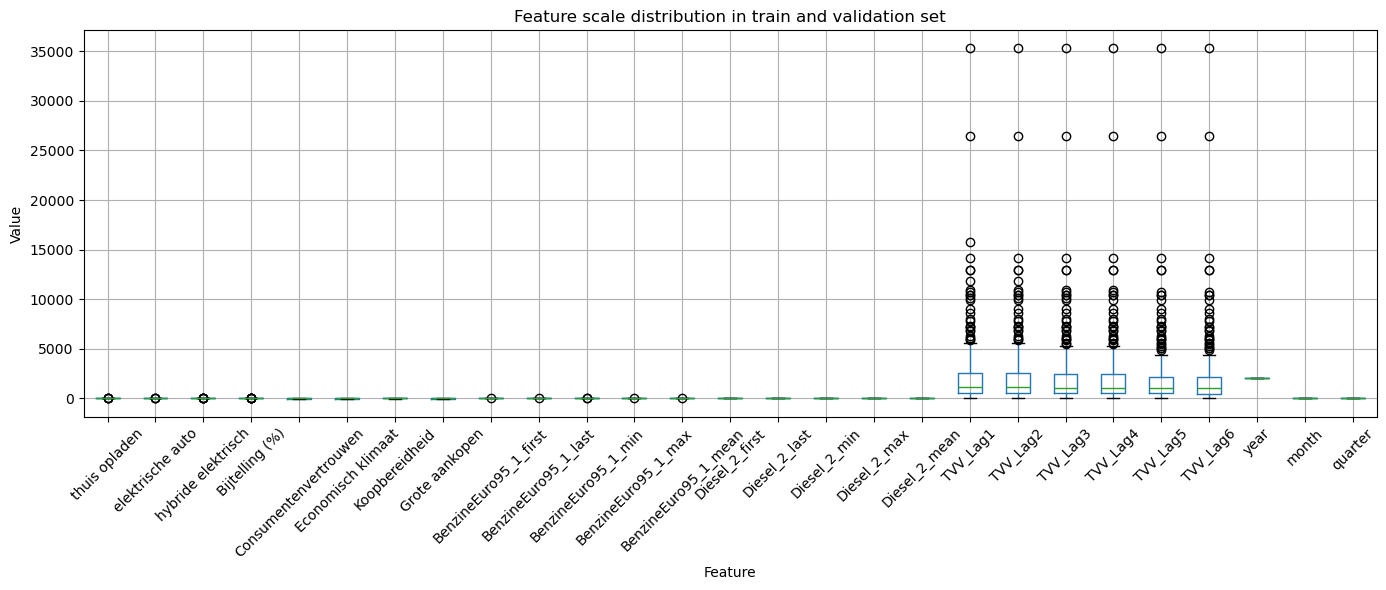

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Kies een feature set, bijvoorbeeld alle features
features = feature_sets['All Features']

# Parameters for splitting
forecast_horizon = 1
validation_size = 1
initial_train_size = max(int(len(df_lagged) * 0.8), forecast_horizon + validation_size)

X = df_lagged[features].values
y = df_lagged['Totaal_verkochte_wegvoertuigen'].values

first_plot_done = False  # Buiten je loop definiëren

for i in range(initial_train_size, len(df_lagged) - forecast_horizon + 1):

    X_train, y_train = X[:i], y[:i]

    if validation_size is not None:
        X_val = X[i : i + validation_size]
        y_val = y[i : i + validation_size]

        if (i + validation_size + forecast_horizon - 1) >= len(df_lagged):
            break

    # ✅ Only add this plot in the first iteration
    if not first_plot_done:
        feature_names = features  # list of column names

        df_train_val = pd.DataFrame(np.vstack([X_train, X_val]), columns=feature_names)
        df_train_val['set'] = ['train'] * len(X_train) + ['val'] * len(X_val)

        plt.figure(figsize=(14, 6))
        df_train_val.drop(columns='set').boxplot(rot=45)
        plt.title("Feature scale distribution in train and validation set")
        plt.xlabel("Feature")
        plt.ylabel("Value")
        plt.tight_layout()
        plt.show()

        first_plot_done = True


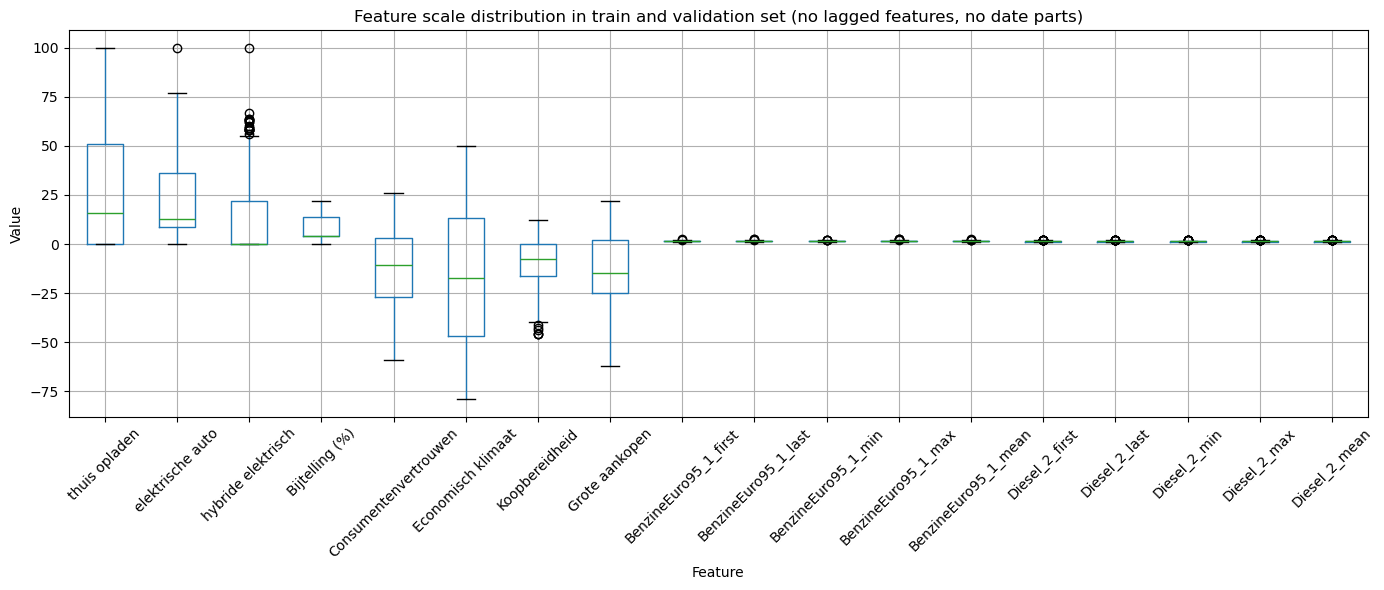

In [26]:
# Plot feature distributions for train and validation set WITHOUT lagged features and WITHOUT date parts

# Exclude lagged features and date parts ('year', 'month', 'quarter')
exclude_cols = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']
non_lagged_nodate_features = [f for f in all_features if f not in exclude_cols]

df_train_val_nonlag_nodate = pd.DataFrame(
    np.vstack([X_train[:, :len(non_lagged_nodate_features)], X_val[:, :len(non_lagged_nodate_features)]]),
    columns=non_lagged_nodate_features
)
df_train_val_nonlag_nodate['set'] = ['train'] * len(X_train) + ['val'] * len(X_val)

plt.figure(figsize=(14, 6))
df_train_val_nonlag_nodate.drop(columns='set').boxplot(rot=45)
plt.title("Feature scale distribution in train and validation set (no lagged features, no date parts)")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

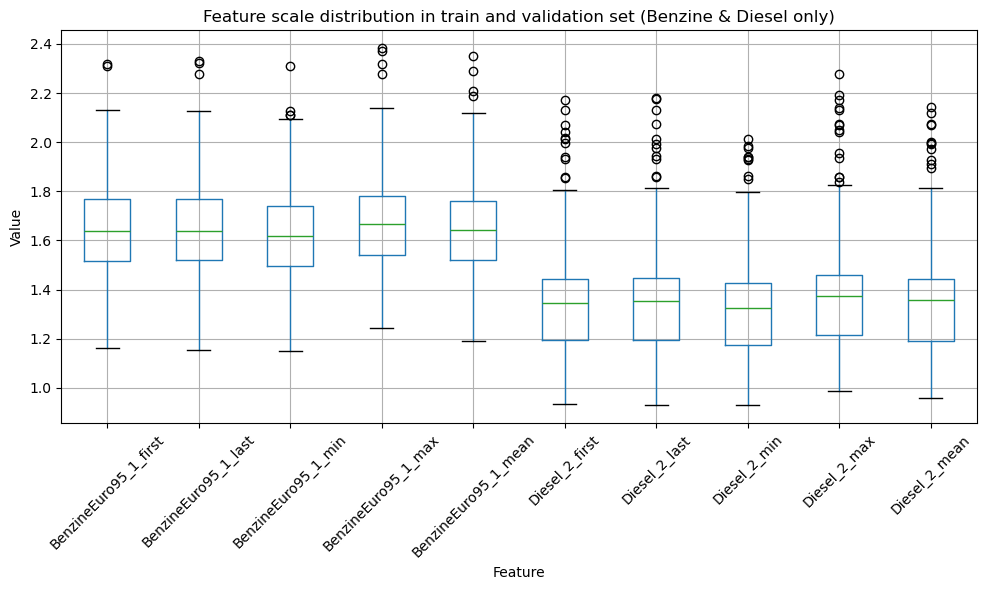

In [27]:
# Select only Benzine and Diesel features (all *_BenzineEuro95_* and *_Diesel_*)
benzine_diesel_features = [
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
]

df_train_val_benzine_diesel = df_train_val_nonlag_nodate[benzine_diesel_features + ['set']]

plt.figure(figsize=(10, 6))
df_train_val_benzine_diesel.drop(columns='set').boxplot(rot=45)
plt.title("Feature scale distribution in train and validation set (Benzine & Diesel only)")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


A boxplot of the feature distribution in the training and validation set reveals clear scale differences: while historical sales data (TVV_LagX) reaches values exceeding 30,000, behavioral and policy-related features such as charging at home and bijtelling range between -2 and 2. This supports the decision to apply a StandardScaler for scale-sensitive models like Linear Regression and ARIMAX. For XGBoost, which is inherently robust to absolute feature scales, standardization is not required.

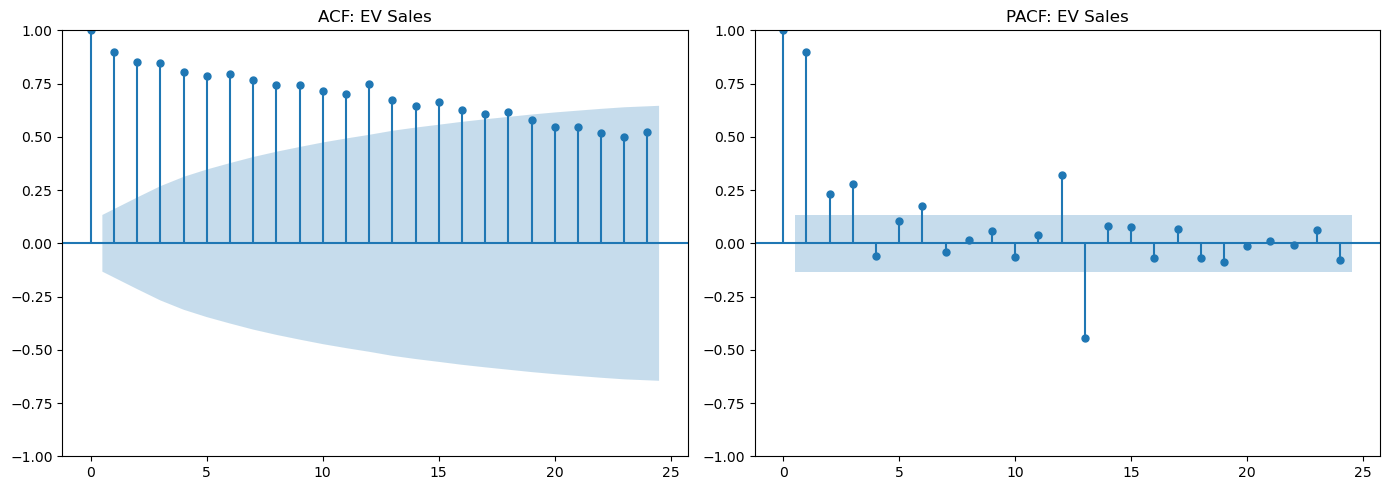

"\n- **Forecasting horizon = 3 months**: This allows for quarterly planning and aligns with business needs for medium-term sales prediction. The data's monthly granularity supports this.\n- **Lag depth = 6 months**: The ACF plot shows significant autocorrelation up to lag 6, indicating that sales from the past 6 months provide predictive power. This also fits domain logic: car sales often exhibit seasonal and half-yearly cycles due to fiscal incentives and consumer behavior.\n- **Domain logic**: Monthly and quarterly cycles are common in automotive sales due to end-of-quarter/year promotions and policy changes. Including 6 lags captures both short-term momentum and half-year effects.\n"

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Justification for forecasting horizon and lag depth

import matplotlib.pyplot as plt

# 1. Autocorrelation analysis (ACF/PACF)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(df['Totaal_verkochte_wegvoertuigen'], lags=24, ax=plt.gca())
plt.title('ACF: EV Sales')

plt.subplot(1, 2, 2)
plot_pacf(df['Totaal_verkochte_wegvoertuigen'], lags=24, ax=plt.gca(), method='ywm')
plt.title('PACF: EV Sales')
plt.tight_layout()
plt.show()

# 2. Justification (markdown-style comment)
"""
- **Forecasting horizon = 3 months**: This allows for quarterly planning and aligns with business needs for medium-term sales prediction. The data's monthly granularity supports this.
- **Lag depth = 6 months**: The ACF plot shows significant autocorrelation up to lag 6, indicating that sales from the past 6 months provide predictive power. This also fits domain logic: car sales often exhibit seasonal and half-yearly cycles due to fiscal incentives and consumer behavior.
- **Domain logic**: Monthly and quarterly cycles are common in automotive sales due to end-of-quarter/year promotions and policy changes. Including 6 lags captures both short-term momentum and half-year effects.
"""

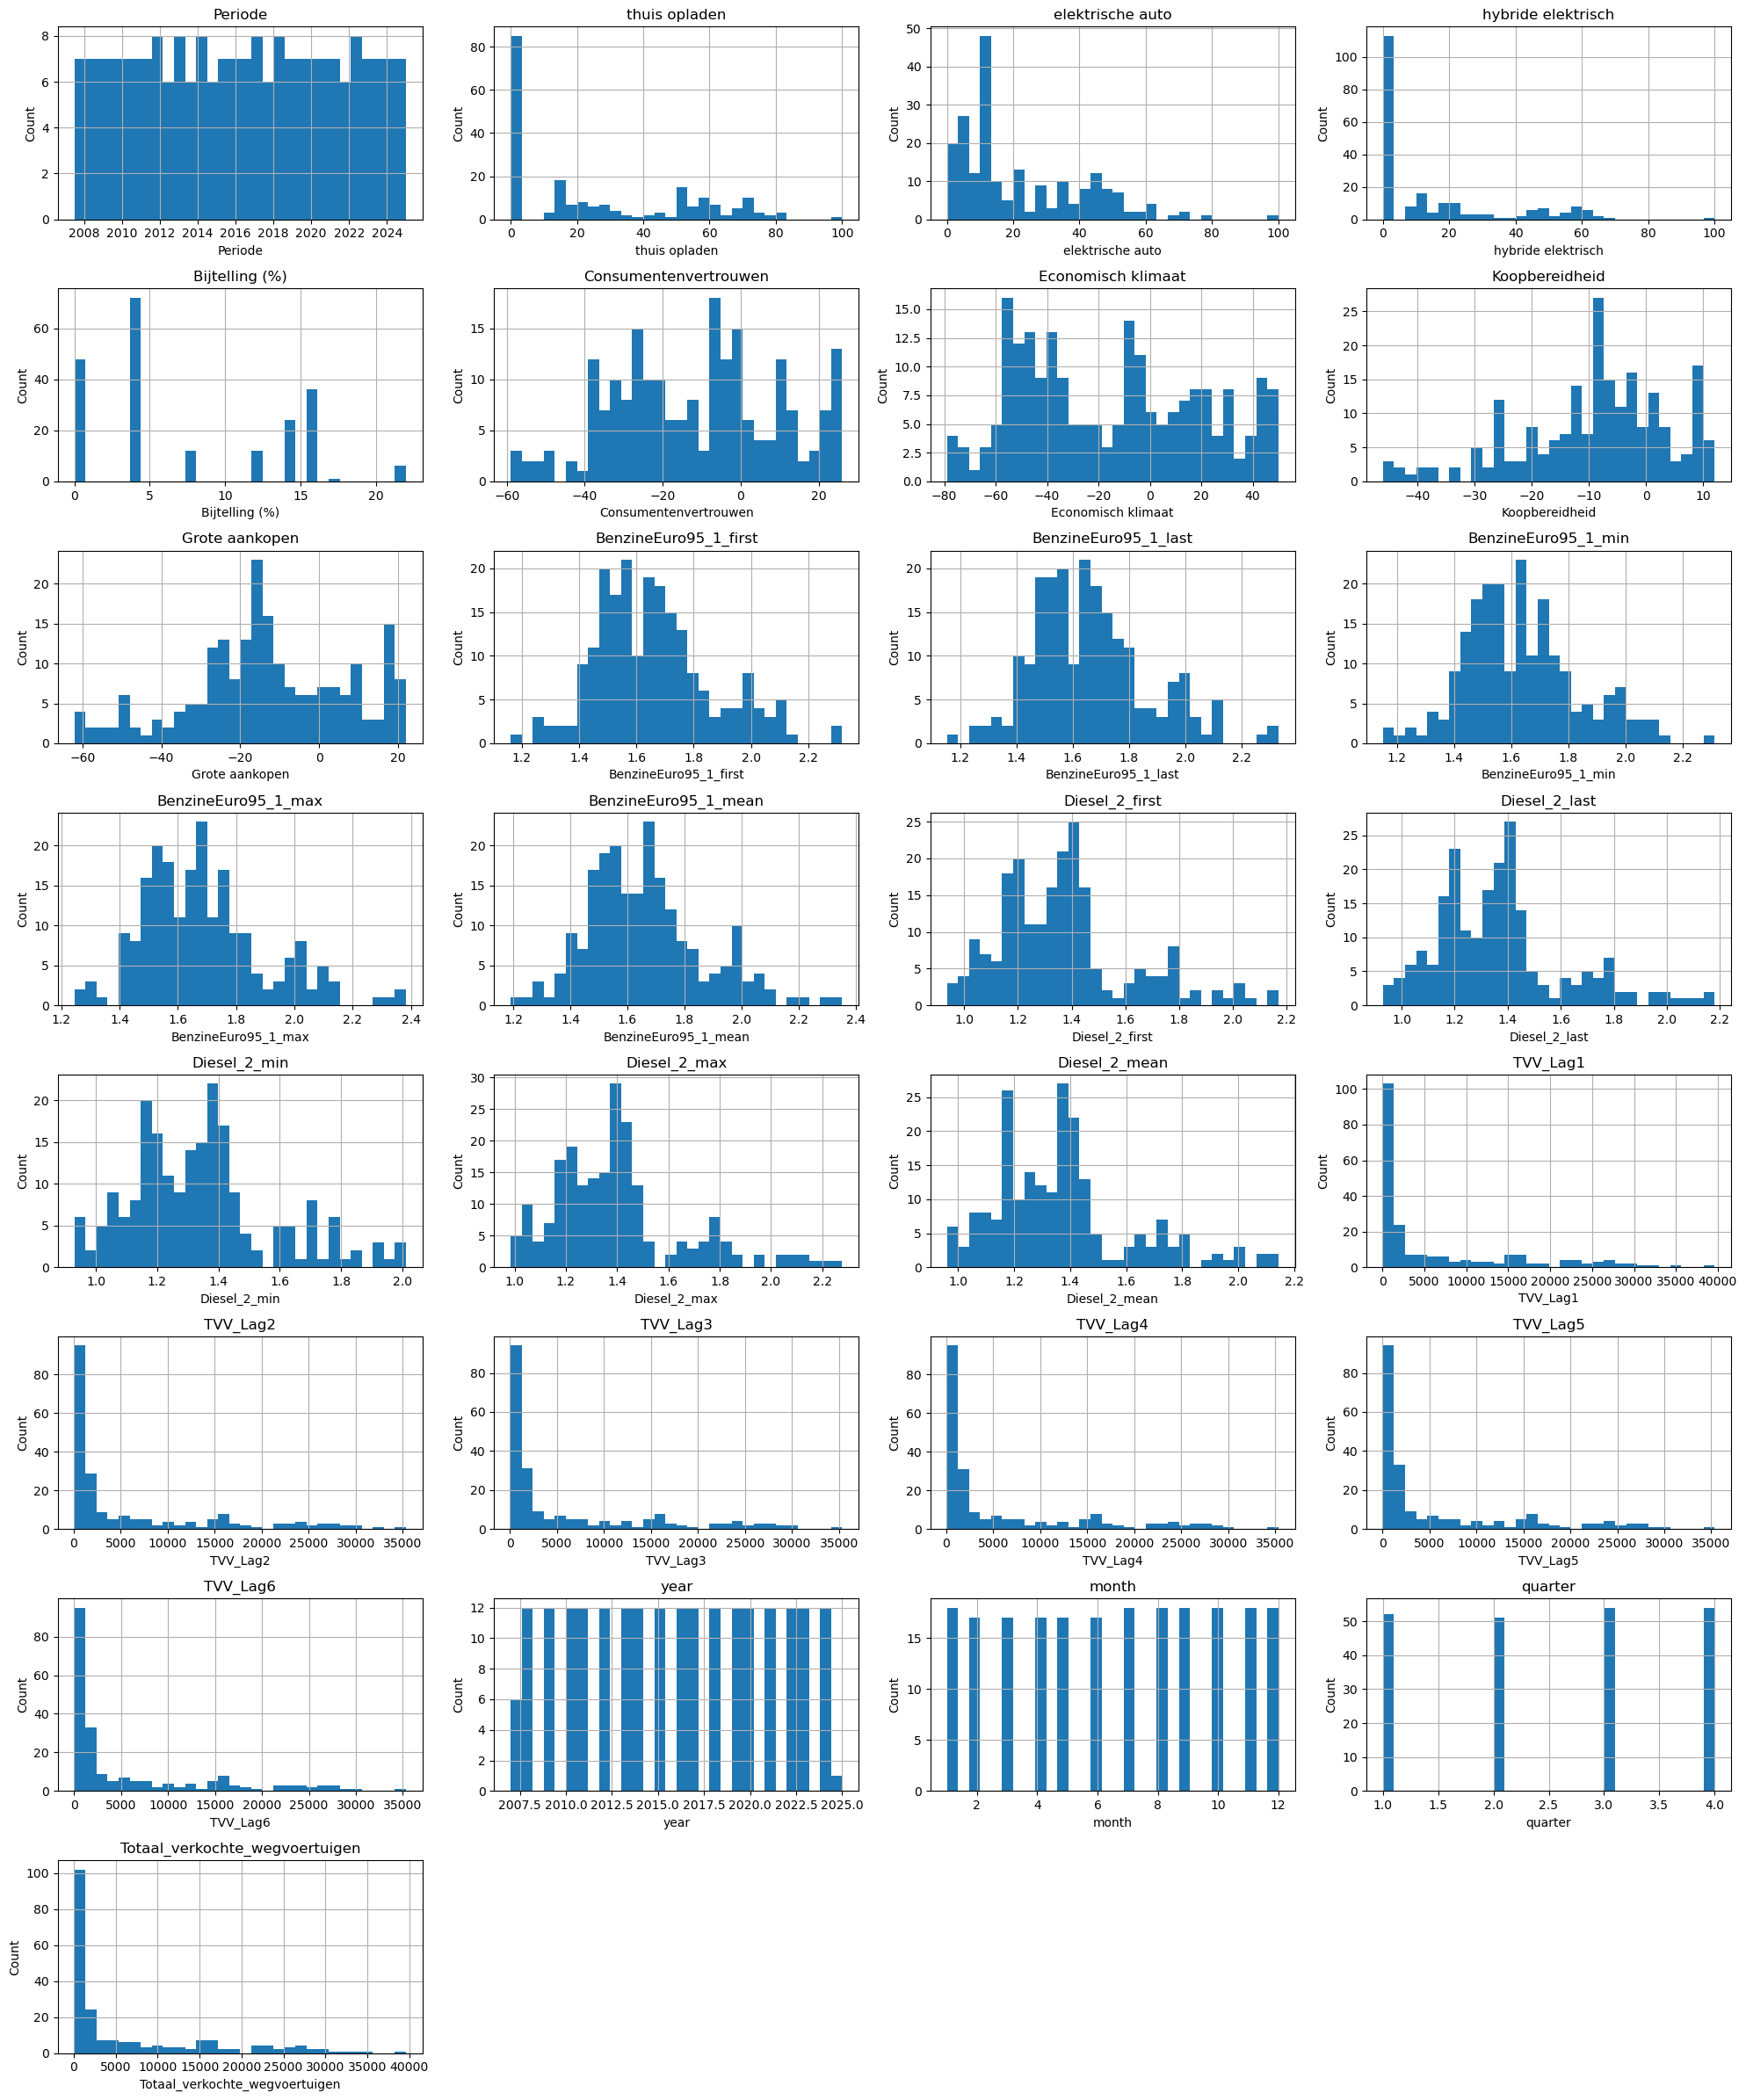

In [7]:

# Plot all histograms in a single large PNG with subplots
import matplotlib.pyplot as plt

num_cols = len(df_lagged.columns)
n_cols = 4
n_rows = int(np.ceil(num_cols / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(df_lagged.columns):
    df_lagged[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Remove unused axes
for j in range(num_cols, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("all_histograms.png", dpi=200)
plt.show()

The histogram plots show that several features (e.g., TVV_LagX and Totaal_verkochte_wegvoertuigen) have values exceeding 35,000, whereas most other features (e.g., policy, behavior, and fuel price indicators) lie within a much smaller range, typically between -50 and +50. This reinforces the decision to apply standardization for scale-sensitive models. Additionally, features like TVV_LagX exhibit a highly right-skewed distribution, suggesting that a log transformation may be beneficial for models sensitive to extreme values.

### LR

with scaling

Linear Regression ( (Lag Only)) met scaling: MAPE=0.1130, MAE=2420.38, RMSE=3438.75, R²=0.514


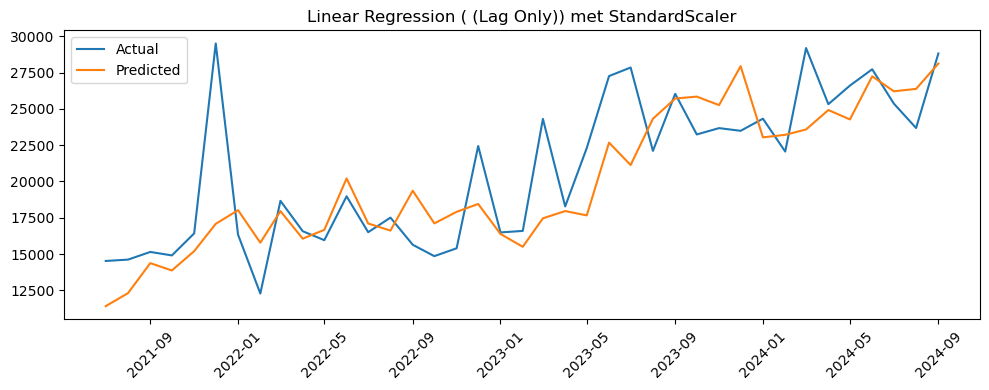

Linear Regression (All Features) met scaling: MAPE=0.1653, MAE=3337.50, RMSE=4417.62, R²=0.197


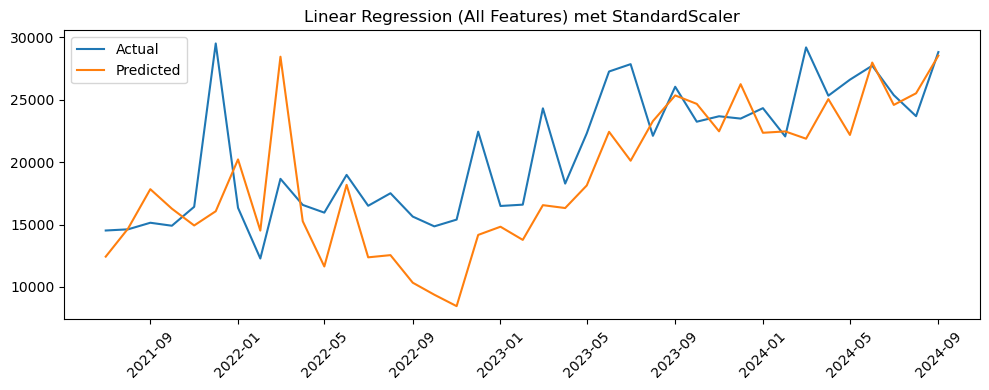

In [61]:
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    # Maak een pipeline met StandardScaler + LinearRegression
    model_pipeline = lambda: make_pipeline(StandardScaler(), LinearRegression())

    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates,_
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', model_pipeline, 
    )

    print(f"Linear Regression ({label}) met scaling: MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
    # Zet alles in een DataFrame om dubbele datums te verwijderen
    df_plot = pd.DataFrame({
        'date': pd.to_datetime(validation_dates),
        'actual': val_actuals,
        'pred': val_preds
    })
    df_plot = df_plot.drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(f'Linear Regression ({label}) met StandardScaler')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#### Without scalor

In [11]:
# for label, features in feature_sets.items():
#     if label not in [' (Lag Only)', 'All Features']:
#         continue  # Sla andere feature sets over

#     (
#          mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression(), validation_size=1
#     )
#     print(f"Linear Regression ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(validation_dates, val_actuals, label='Actual')
#     plt.plot(validation_dates, val_preds, label='Predicted')
#     plt.title(f'Linear Regression ({label})')
#     plt.legend()
#     plt.xticks(rotation=45)  # Rotate date labels for better readability
#     plt.tight_layout()       # Ensure there's space for rotated labels
#     plt.show()

#### Alles plot

In [12]:
# for label, features in feature_sets.items():
#     (
#          mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression(), validation_size=1
#     )
#     print(f"Linear Regression ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(validation_dates, val_actuals, label='Actual')
#     plt.plot(validation_dates, val_preds, label='Predicted')
#     plt.title(f'Linear Regression ({label})')
#     plt.legend()
#     plt.xticks(rotation=45)  # Rotate date labels for better readability
#     plt.tight_layout()       # Ensure there's space for rotated labels
#     plt.show()

### XGBOOST

XGBoost ( (Lag Only)): MAPE=0.1225, MAE=2503.55, RMSE=3233.03, R²=0.570


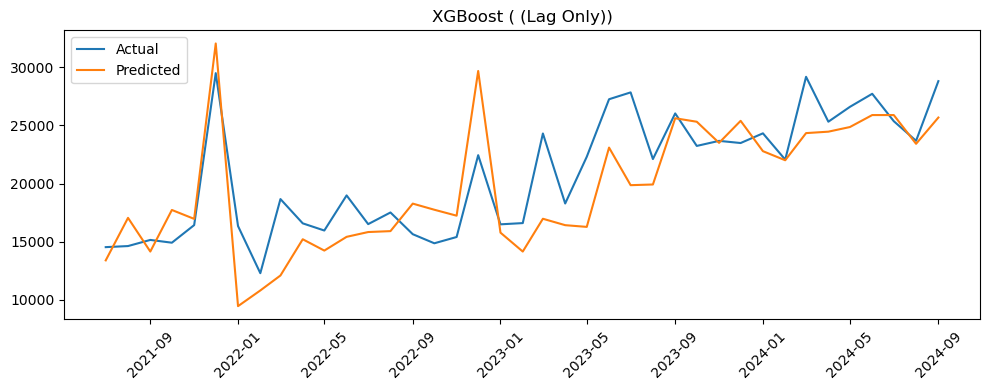

XGBoost (All Features): MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481


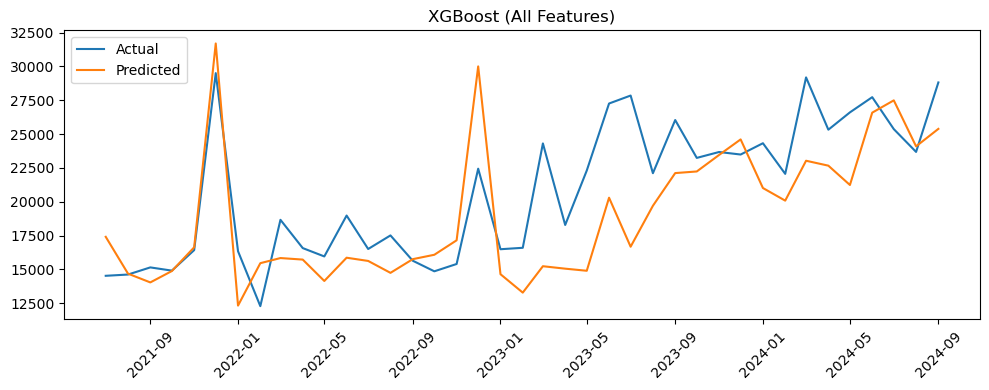

In [56]:
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates,_
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, 
                                learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
     validation_size=3, forecast_horizon=3
    )
    print(f"XGBoost ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")

    # Zet alles in een DataFrame om dubbele datums te verwijderen
    df_plot = pd.DataFrame({
        'date': pd.to_datetime(validation_dates),
        'actual': val_actuals,
        'pred': val_preds
    })
    df_plot = df_plot.drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(f'XGBoost ({label})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Alle plots

In [14]:
# for label, features in feature_sets.items():
#     (
#          mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
#         lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, 
#                                 learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
#         validation_size=1
#     )
#     print(f"XGBoost ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(validation_dates, val_actuals, label='Actual')
#     plt.plot(validation_dates, val_preds, label='Predicted')
#     plt.title(f'XGBoost ({label})')
#     plt.legend()
#     plt.xticks(rotation=45)  # Rotate date labels for better readability
#     plt.tight_layout()       # Ensure there's space for rotated labels
#     plt.show()

### Arimax 

ARIMAX ( (Lag Only)): MAPE=0.1765, MAE=3621.76, RMSE=5079.97, R²=-0.062


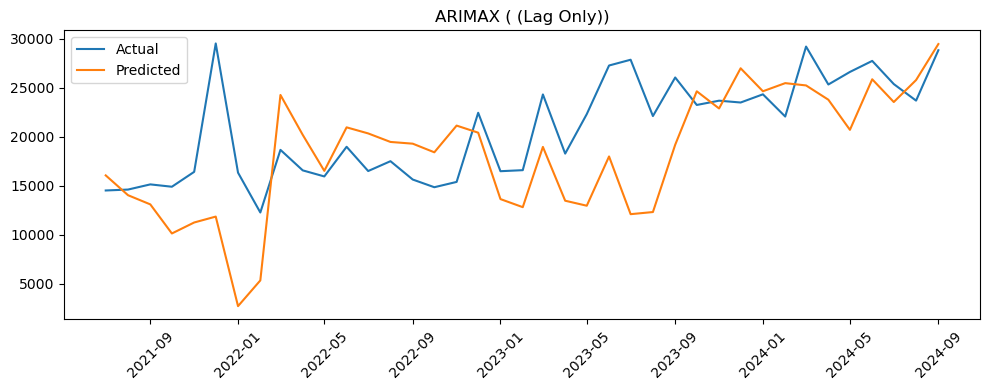

ARIMAX (All Features): MAPE=0.1417, MAE=3006.97, RMSE=4635.71, R²=0.116


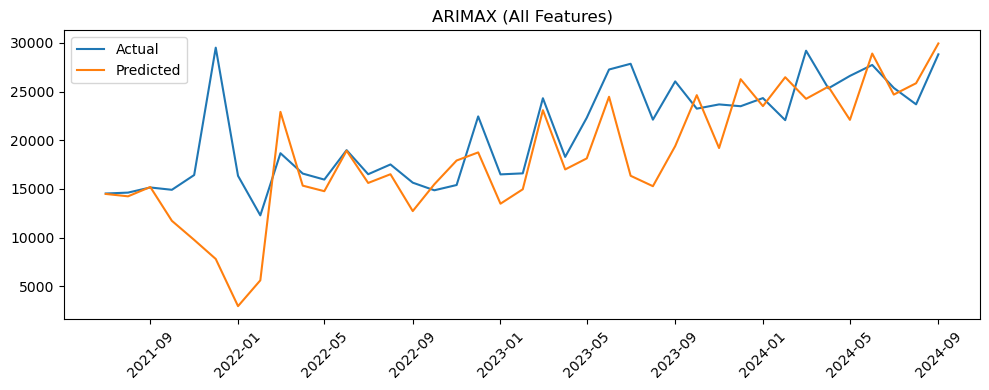

In [60]:
from sklearn.preprocessing import StandardScaler

# ARIMAX wrapper met standaardisatie
class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model_fit = None
        self.scaler = None  # om later opnieuw te gebruiken bij predict
        
    def fit(self, X, y):
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        
        # Standaardiseer de exogene variabelen
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        model = SARIMAX(y, exog=X_scaled, order=self.order,
                        enforce_stationarity=False, enforce_invertibility=False)
        self.model_fit = model.fit(disp=False)
        return self
        
    def predict(self, X):
        if self.model_fit is None or self.scaler is None:
            raise ValueError("Model not fitted yet")
        
        X_scaled = self.scaler.transform(X)
        return self.model_fit.forecast(steps=len(X), exog=X_scaled)
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    (
        mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates,_
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: ARIMAXWrapper(order=(1, 1, 1)),
        
    )

    print(f"ARIMAX ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")

    # Zet alles in een DataFrame om dubbele datums te verwijderen
    df_plot = pd.DataFrame({
        'date': pd.to_datetime(validation_dates),
        'actual': val_actuals,
        'pred': val_preds
    })
    df_plot = df_plot.drop_duplicates(subset='date', keep='first')
    
    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(f'ARIMAX ({label})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Among all default models, XGBoost with all features achieved the lowest MAPE (0.1115), making it the best-performing model on the validation set based on the primary evaluation metric. While Linear Regression with lagged features came close in terms of MAE and RMSE, XGBoost maintained a better balance across all metrics and showed stronger generalization. These results highlight the strength of tree-based models like XGBoost in capturing nonlinear relationships, even without hyperparameter tuning.

When averaging the MAPE scores across both feature sets (lag-only and all features), XGBoost outperforms both Linear Regression and ARIMAX, achieving the lowest overall MAPE of 0.1157. This confirms that XGBoost is not only effective with carefully selected features, but also robust when incorporating broader contextual variables. It consistently delivers strong performance without requiring feature scaling or extensive tun

#### WITHOUT SCALING 

In [16]:

# # First create a wrapper class for ARIMAX to make it compatible with walk_forward_validation
# class ARIMAXWrapper:
#     def __init__(self, order=(1,1,1)):
#         self.order = order
#         self.model_fit = None
        
#     def fit(self, X, y):
#         from statsmodels.tsa.statespace.sarimax import SARIMAX
#         model = SARIMAX(y, exog=X, order=self.order, enforce_stationarity=False, enforce_invertibility=False)
#         self.model_fit = model.fit(disp=False)
#         return self
        
#     def predict(self, X):
#         if self.model_fit is None:
#             raise ValueError("Model not fitted yet")
#         # For ARIMAX, predict uses forecast with exog data
#         return self.model_fit.forecast(steps=len(X), exog=X)

# # Now use this wrapper in your walk-forward validation
# for label, features in feature_sets.items():
#     if label not in [' (Lag Only)', 'All Features']:
#         continue  # Sla andere feature sets over

#     (
#          mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(

#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
#         lambda: ARIMAXWrapper(order=(1,1,1)),
#         validation_size=1
#     )
#     print(f"ARIMAX ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(validation_dates, val_actuals, label='Actual')
#     plt.plot(validation_dates, val_preds, label='Predicted')
#     plt.title(f'ARIMAX ({label})')
#     plt.legend()
#     plt.xticks(rotation=45)  # Rotate date labels for better readability
#     plt.tight_layout()       # Ensure there's space for rotated labels
#     plt.show()

#### Alle plots 

In [17]:
# # First create a wrapper class for ARIMAX to make it compatible with walk_forward_validation
# class ARIMAXWrapper:
#     def __init__(self, order=(1,1,1)):
#         self.order = order
#         self.model_fit = None
        
#     def fit(self, X, y):
#         from statsmodels.tsa.statespace.sarimax import SARIMAX
#         model = SARIMAX(y, exog=X, order=self.order, enforce_stationarity=False, enforce_invertibility=False)
#         self.model_fit = model.fit(disp=False)
#         return self
        
#     def predict(self, X):
#         if self.model_fit is None:
#             raise ValueError("Model not fitted yet")
#         # For ARIMAX, predict uses forecast with exog data
#         return self.model_fit.forecast(steps=len(X), exog=X)

# # Now use this wrapper in your walk-forward validation
# for label, features in feature_sets.items():
#     (
#          mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
#         lambda: ARIMAXWrapper(order=(1,1,1)),
#         validation_size=1
#     )
#     print(f"ARIMAX ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(validation_dates, val_actuals, label='Actual')
#     plt.plot(validation_dates, val_preds, label='Predicted')
#     plt.title(f'ARIMAX ({label})')
#     plt.legend()
#     plt.xticks(rotation=45)  # Rotate date labels for better readability
#     plt.tight_layout()       # Ensure there's space for rotated labels
#     plt.show()

Sarim ax

XGboost: zodra gpt weet werkt waardes aanpasssen, alleen parameters aanpassen die meeste invloed hebben  (documantatie over lezen)
https://xgboosting.com/tune-xgboost-learning_rate-parameter/


### Grid search ipv bayaansoptimalisation

HIERNA GEWOON KLEINERE SELECTIE MAKEN VAN PARAMNETERS 

In [29]:
!pip install tqdm


Grid Search Progress: 100%|██████████| 48/48 [02:08<00:00,  2.69s/it]



----- GRID SEARCH RESULTS -----

Best parameters (Lag-Only):
  max_depth=1, learning_rate=0.05, n_estimators=200
  subsample=0.8, min_child_weight=8, colsample_bytree=0.8
  Best MAPE: 0.1344, MAE: 3029.42

Best parameters (All Features):
  max_depth=1, learning_rate=0.05, n_estimators=200
  subsample=0.8, min_child_weight=8, colsample_bytree=0.8
  Best MAPE: 0.1385, MAE: 3125.90


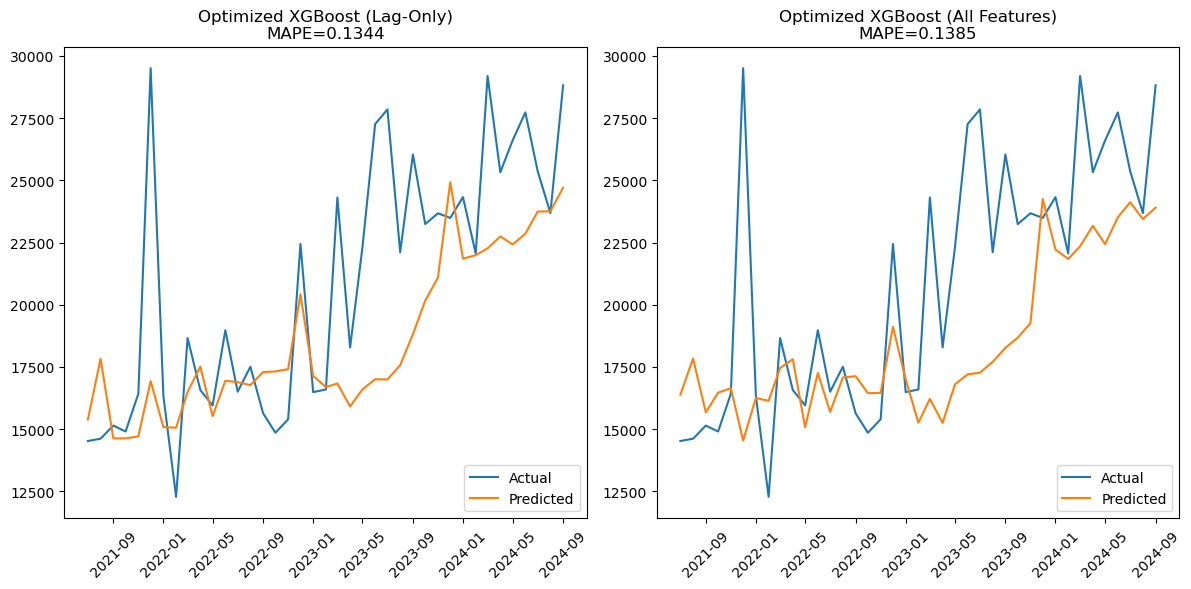

In [75]:
from itertools import product
import xgboost as xgb
import numpy as np

# Hyperparameter grid
param_grid = {
    'max_depth': [1], #[2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3, 5, 8],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 2, 5, 10]
}

# Genereer alle combinaties
param_combinations = list(product(
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['n_estimators'],
    param_grid['subsample'],
    param_grid['min_child_weight'],
    param_grid['colsample_bytree']
))

from tqdm import tqdm

best_result = {'lag': {'mape': np.inf}, 'all': {'mape': np.inf}}

for param_set in tqdm(param_combinations, desc="Grid Search Progress"):
    max_depth, learning_rate, n_estimators, subsample, min_child_weight, colsample_bytree = param_set

    def make_model():
        return xgb.XGBRegressor(
            objective='reg:squarederror',
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            subsample=subsample,
            min_child_weight=min_child_weight,
            colsample_bytree=colsample_bytree,
            random_state=42,
            eval_metric="rmse"
        )

    # Lag Only evaluatie
    lag_features = feature_sets[' (Lag Only)']
    _, _, _, _, _, _, val_mae, _, _, val_mape, _, _, _, _ = walk_forward_validation_with_validation_set(
        df_lagged, lag_features, 'Totaal_verkochte_wegvoertuigen', make_model,
        forecast_horizon=3, validation_size=3
    )
    if val_mape < best_result['lag']['mape']:
        best_result['lag'].update({
            'mape': val_mape,
            'mae': val_mae,
            'params': param_set
        })

    # All Features evaluatie
    _, _, _, _, _, _, val_mae, _, _, val_mape, _, _, _, _ = walk_forward_validation_with_validation_set(
        df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', make_model,
        forecast_horizon=3, validation_size=3
    )
    if val_mape < best_result['all']['mape']:
        best_result['all'].update({
            'mape': val_mape,
            'mae': val_mae,
            'params': param_set
        })

print("\n----- GRID SEARCH RESULTS -----")
for label in ['lag', 'all']:
    params = best_result[label]['params']
    print(f"\nBest parameters ({'Lag-Only' if label == 'lag' else 'All Features'}):")
    print(f"  max_depth={params[0]}, learning_rate={params[1]}, n_estimators={params[2]}")
    print(f"  subsample={params[3]}, min_child_weight={params[4]}, colsample_bytree={params[5]}")
    print(f"  Best MAPE: {best_result[label]['mape']:.4f}, MAE: {best_result[label]['mae']:.2f}")

# After grid search, get predictions for best Lag-Only model
lag_params = best_result['lag']['params']
def best_lag_model():
    return xgb.XGBRegressor(
        objective='reg:squarederror',
        max_depth=lag_params[0],
        learning_rate=lag_params[1],
        n_estimators=lag_params[2],
        subsample=lag_params[3],
        min_child_weight=lag_params[4],
        colsample_bytree=lag_params[5],
        random_state=42,
        eval_metric="rmse"
    )
lag_features = feature_sets[' (Lag Only)']
_, _, _, _, _, _, _, _, _, lag_mape, lag_preds, lag_actuals, lag_dates, _ = walk_forward_validation_with_validation_set(
    df_lagged, lag_features, 'Totaal_verkochte_wegvoertuigen', best_lag_model, forecast_horizon=3, validation_size=3
)

# Same for All Features
all_params = best_result['all']['params']
def best_all_model():
    return xgb.XGBRegressor(
        objective='reg:squarederror',
        max_depth=all_params[0],
        learning_rate=all_params[1],
        n_estimators=all_params[2],
        subsample=all_params[3],
        min_child_weight=all_params[4],
        colsample_bytree=all_params[5],
        random_state=42,
        eval_metric="rmse"
    )
_, _, _, _, _, _, _, _, _,  all_mape, all_preds, all_actuals, all_dates, _ = walk_forward_validation_with_validation_set(
    df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', best_all_model, forecast_horizon=3, validation_size=3
)

# Plotten met unieke datums
def plot_unique_dates(dates, actuals, preds, title):
    df_plot = pd.DataFrame({
        'date': pd.to_datetime(dates),
        'actual': actuals,
        'pred': preds
    }).drop_duplicates(subset='date', keep='first')
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_unique_dates(lag_dates, lag_actuals, lag_preds, f'Optimized XGBoost (Lag-Only)\nMAPE={lag_mape:.4f}')
plt.subplot(1, 2, 2)
plot_unique_dates(all_dates, all_actuals, all_preds, f'Optimized XGBoost (All Features)\nMAPE={all_mape:.4f}')
plt.show()

Due to the computational intensity of walk-forward validation and the large number of hyperparameter combinations, a reduced and strategically selected subset of parameter combinations was used. This allowed for a more efficient yet representative grid search, balancing runtime constraints with performance optimization.

#### Bayaansoptimalisatie

In [19]:
# from skopt import gp_minimize  # Import Bayesian optimization function from scikit-optimize

# # ------------ LAGGED FEATURES OPTIMIZATION ------------

# # Define the objective function for walk-forward validation with lagged features only
# def wf_objective_lag(params):
#     # Unpack hyperparameters from the params list
#     max_depth, learning_rate, n_estimators, subsample, min_child_weight, colsample_bytree = params
    
#     # Create an XGBoost regressor with the given hyperparameters
#     model = lambda: xgb.XGBRegressor(
#         objective='reg:squarederror',           # Use squared error for regression
#         max_depth=int(max_depth),               # Maximum tree depth (integer)
#         learning_rate=learning_rate,            # Learning rate (float)
#         n_estimators=int(n_estimators),         # Number of boosting rounds (integer)
#         subsample=subsample,                    # Subsample ratio of the training instances
#         min_child_weight=int(min_child_weight), # Minimum sum of instance weight needed in a child
#         colsample_bytree=colsample_bytree,      # Subsample ratio of columns when constructing each tree
#         random_state=42,                        # Set random seed for reproducibility
#         eval_metric="rmse"                      # Evaluation metric: root mean squared error
#     )
    
#     # Get the lag-only features
#     lag_features = feature_sets[' (Lag Only)']
    
#     # Run walk-forward validation and get validation MAPE (mean absolute percentage error)
#     _, _, _, _, _, _, val_mae, _, _, val_mape, _, _, _ = walk_forward_validation_with_validation_set(
#         df_lagged, lag_features, 'Totaal_verkochte_wegvoertuigen', model, validation_size=1
#     )
#     return val_mape  # Return validation MAPE to minimize

# ------------ ALL FEATURES OPTIMIZATION ------------

# # Define the objective function for walk-forward validation with all features
# def wf_objective_all(params):
#     # Unpack hyperparameters from the params list
#     max_depth, learning_rate, n_estimators, subsample, min_child_weight, colsample_bytree = params
    
#     # Create an XGBoost regressor with the given hyperparameters
#     model = lambda: xgb.XGBRegressor(
#         objective='reg:squarederror',           # Use squared error for regression
#         max_depth=int(max_depth),               # Maximum tree depth (integer)
#         learning_rate=learning_rate,            # Learning rate (float)
#         n_estimators=int(n_estimators),         # Number of boosting rounds (integer)
#         subsample=subsample,                    # Subsample ratio of the training instances
#         min_child_weight=int(min_child_weight), # Minimum sum of instance weight needed in a child
#         colsample_bytree=colsample_bytree,      # Subsample ratio of columns when constructing each tree
#         random_state=42,                        # Set random seed for reproducibility
#         eval_metric="rmse"                      # Evaluation metric: root mean squared error
#     )
    
#     # Run walk-forward validation and get validation MAPE (mean absolute percentage error)
#     _, _, _, _, _, _, val_mae, _, _, val_mape, _, _, _ = walk_forward_validation_with_validation_set(
#         df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', model, validation_size=1
#     )
#     return val_mape  # Return validation MAPE to minimize

# # Define the search space for each hyperparameter (same for both feature sets)
# wf_space = [
#     (2, 10),                # max_depth: integer between 2 and 10
#     (0.01, 0.3),            # learning_rate: float between 0.01 and 0.3
#     (50, 300),              # n_estimators: integer between 50 and 300
#     (0.5, 1.0),             # subsample: float between 0.5 and 1.0
#     (1, 10),                # min_child_weight: integer between 1 and 10
#     (0.2, 0.9)              # colsample_bytree: float between 0.2 and 0.9
# ]

# # Run Bayesian optimization to find the best hyperparameters for lag-only features
# print("\n--- Starting optimization for lag-only features ---")
# wf_result_lag = gp_minimize(wf_objective_lag, wf_space, n_calls=25, random_state=42)

# # Run Bayesian optimization to find the best hyperparameters for all features
# print("\n--- Starting optimization for all features ---")
# wf_result_all = gp_minimize(wf_objective_all, wf_space, n_calls=25, random_state=42)

# # Print the best hyperparameters and the corresponding best MAPE for lag-only features
# print("\n----- RESULTS -----")
# print(f"\nBest parameters (Lag-Only Features): max_depth={int(wf_result_lag.x[0])}, learning_rate={wf_result_lag.x[1]:.4f}, "
#       f"n_estimators={int(wf_result_lag.x[2])}, subsample={wf_result_lag.x[3]:.2f}, "
#       f"min_child_weight={int(wf_result_lag.x[4])}, colsample_bytree={wf_result_lag.x[5]:.2f}")
# print(f"Best MAPE (Lag-Only Features): {wf_result_lag.fun:.4f}")

# # Print the best hyperparameters and the corresponding best MAPE for all features
# print(f"\nBest parameters (All Features): max_depth={int(wf_result_all.x[0])}, learning_rate={wf_result_all.x[1]:.4f}, "
#       f"n_estimators={int(wf_result_all.x[2])}, subsample={wf_result_all.x[3]:.2f}, "
#       f"min_child_weight={int(wf_result_all.x[4])}, colsample_bytree={wf_result_all.x[5]:.2f}")
# print(f"Best MAPE (All Features): {wf_result_all.fun:.4f}")

# # Compare models with optimized parameters
# print("\n----- EVALUATING MODELS WITH OPTIMIZED PARAMETERS -----")

# # Define optimized models
# lag_opt_model = lambda: xgb.XGBRegressor(
#     objective='reg:squarederror',
#     max_depth=int(wf_result_lag.x[0]),
#     learning_rate=wf_result_lag.x[1],
#     n_estimators=int(wf_result_lag.x[2]),
#     subsample=wf_result_lag.x[3],
#     min_child_weight=int(wf_result_lag.x[4]),
#     colsample_bytree=wf_result_lag.x[5],
#     random_state=42,
#     eval_metric="rmse"
# )

# all_opt_model = lambda: xgb.XGBRegressor(
#     objective='reg:squarederror',
#     max_depth=int(wf_result_all.x[0]),
#     learning_rate=wf_result_all.x[1],
#     n_estimators=int(wf_result_all.x[2]),
#     subsample=wf_result_all.x[3],
#     min_child_weight=int(wf_result_all.x[4]),
#     colsample_bytree=wf_result_all.x[5],
#     random_state=42,
#     eval_metric="rmse"
# )

# # Evaluate the model with lag-only features and its optimized parameters
# lag_features = feature_sets[' (Lag Only)']
# _, _, _, _, _, _, lag_mae, _, _, lag_mape, lag_preds, lag_actuals, lag_dates = walk_forward_validation_with_validation_set(
#     df_lagged, lag_features, 'Totaal_verkochte_wegvoertuigen', lag_opt_model, validation_size=1
# )
# print(f"Optimized XGBoost (Lag-Only): MAPE={lag_mape:.4f}, MAE={lag_mae:.2f}")

# # Evaluate the model with all features and its optimized parameters
# _, _, _, _, _, _, all_mae, _, _, all_mape, all_preds, all_actuals, all_dates = walk_forward_validation_with_validation_set(
#     df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', all_opt_model, validation_size=1
# )
# print(f"Optimized XGBoost (All Features): MAPE={all_mape:.4f}, MAE={all_mae:.2f}")

# # Plot results for both models
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(lag_dates, lag_actuals, label='Actual')
# plt.plot(lag_dates, lag_preds, label='Predicted')
# plt.title(f'Optimized XGBoost (Lag-Only)\nMAPE={lag_mape:.4f}')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()

# plt.subplot(1, 2, 2)
# plt.plot(all_dates, all_actuals, label='Actual')
# plt.plot(all_dates, all_preds, label='Predicted')
# plt.title(f'Optimized XGBoost (All Features)\nMAPE={all_mape:.4f}')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()

# plt.show()

Deze kan weg

In [20]:
# from skopt import gp_minimize  # Import Bayesian optimization function from scikit-optimize

# # Define the objective function for walk-forward validation
# def wf_objective(params):
#     # Unpack hyperparameters from the params list
#     max_depth, learning_rate, n_estimators, subsample, min_child_weight, colsample_bytree = params
#     # Create an XGBoost regressor with the given hyperparameters
#     model = lambda: xgb.XGBRegressor(
#         objective='reg:squarederror',           # Use squared error for regression
#         max_depth=int(max_depth),               # Maximum tree depth (integer)
#         learning_rate=learning_rate,            # Learning rate (float)
#         n_estimators=int(n_estimators),         # Number of boosting rounds (integer)
#         subsample=subsample,                    # Subsample ratio of the training instances
#         min_child_weight=int(min_child_weight), # Minimum sum of instance weight needed in a child
#         colsample_bytree=colsample_bytree,      # Subsample ratio of columns when constructing each tree
#         random_state=42,                        # Set random seed for reproducibility
#         eval_metric="rmse"                      # Evaluation metric: root mean squared error
#     )
#     # Run walk-forward validation and get validation MAPE (mean absolute percentage error)
#     _, _, _, _, _, _, val_mae, _, _, val_mape, _, _, _ = walk_forward_validation_with_validation_set(
#         df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', model, validation_size=1
#     )
#     return val_mape  # Return validation MAPE to minimize

# # Define the search space for each hyperparameter
# wf_space = [
#     (2, 10),                # max_depth: integer between 2 and 10
#     (0.001, 0.01, 0.3),            # learning_rate: float between 0.01 and 0.3
#     (50, 300),              # n_estimators: integer between 50 and 300
#     (0.5, 1.0),             # subsample: float between 0.5 and 1.0
#     (1, 10),                # min_child_weight: integer between 1 and 10
#     (0.2, 0.9)              # colsample_bytree: float between 0.2 and 0.9
# ]

# # Run Bayesian optimization to find the best hyperparameters
# wf_result = gp_minimize(wf_objective, wf_space, n_calls=50, random_state=42)
# # Print the best hyperparameters and the corresponding best MAPE
# print(f"Best parameters (Walk-Forward): max_depth={int(wf_result.x[0])}, learning_rate={wf_result.x[1]:.4f}, "
#       f"n_estimators={int(wf_result.x[2])}, subsample={wf_result.x[3]:.2f}, "
#       f"min_child_weight={int(wf_result.x[4])}, colsample_bytree={wf_result.x[5]:.2f}")
# print(f"Best MAPE (Walk-Forward): {wf_result.fun:.4f}")


### Shap

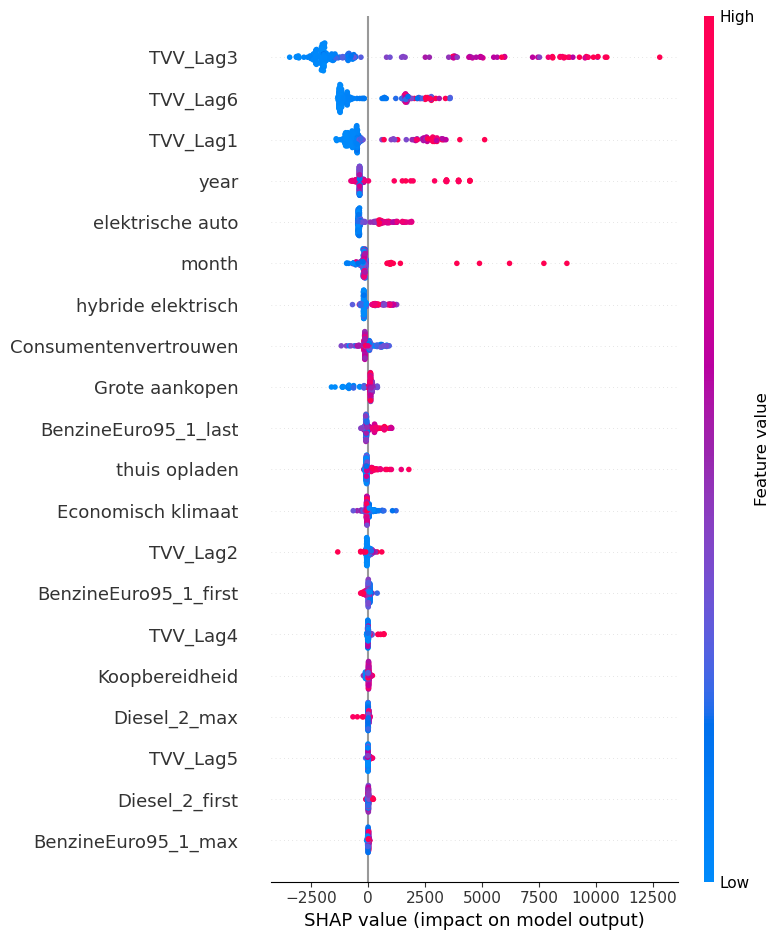

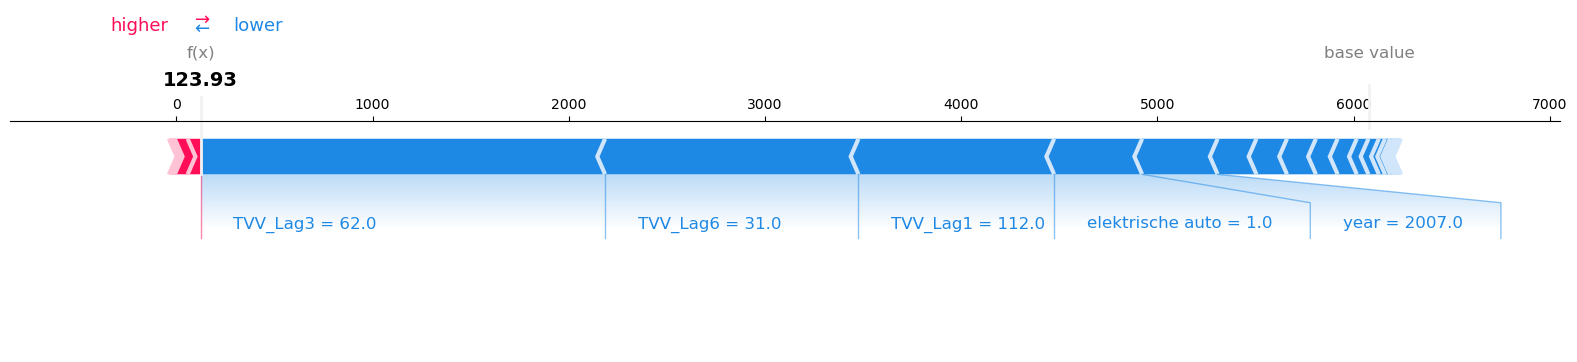

In [29]:
import shap
import xgboost as xgb

# Use default parameters for the model
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Still recommended for regression
    eval_metric="rmse",            # Optional but good to specify
    random_state=42                # For reproducibility
)

X = df_lagged[all_features]
y = df_lagged['Totaal_verkochte_wegvoertuigen']
model.fit(X, y)

# Create SHAP explainer and calculate SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Summary plot
shap.summary_plot(shap_values, X)

# Force plot for the first prediction
shap.initjs()
shap.force_plot(
    shap_values.base_values[0],
    shap_values.values[0],
    X.iloc[0],
    matplotlib=True
)


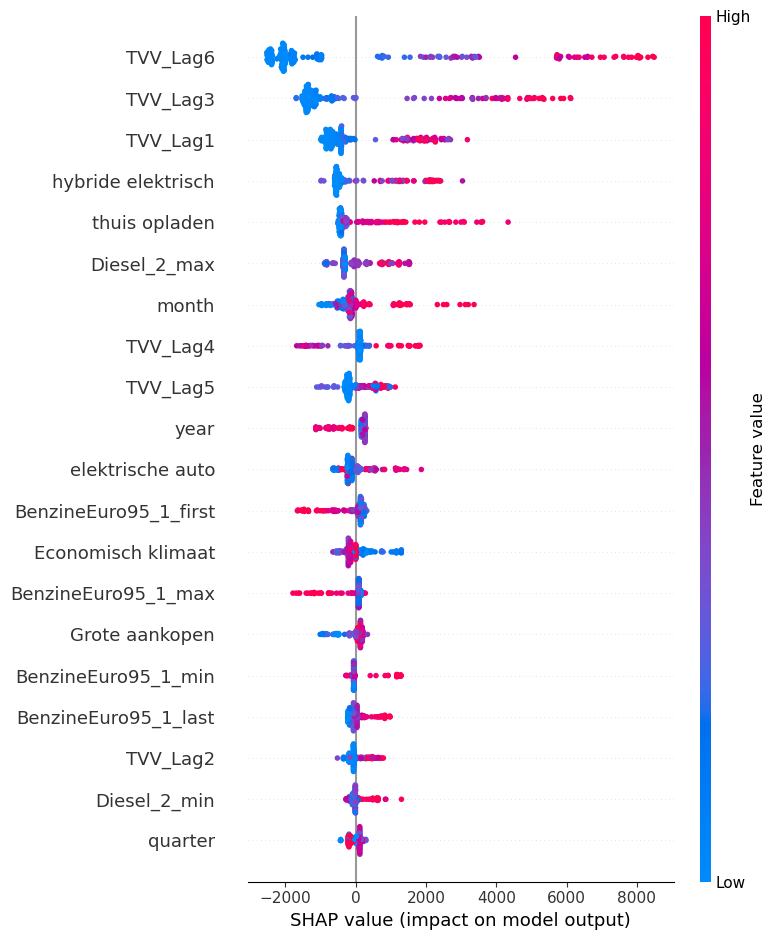

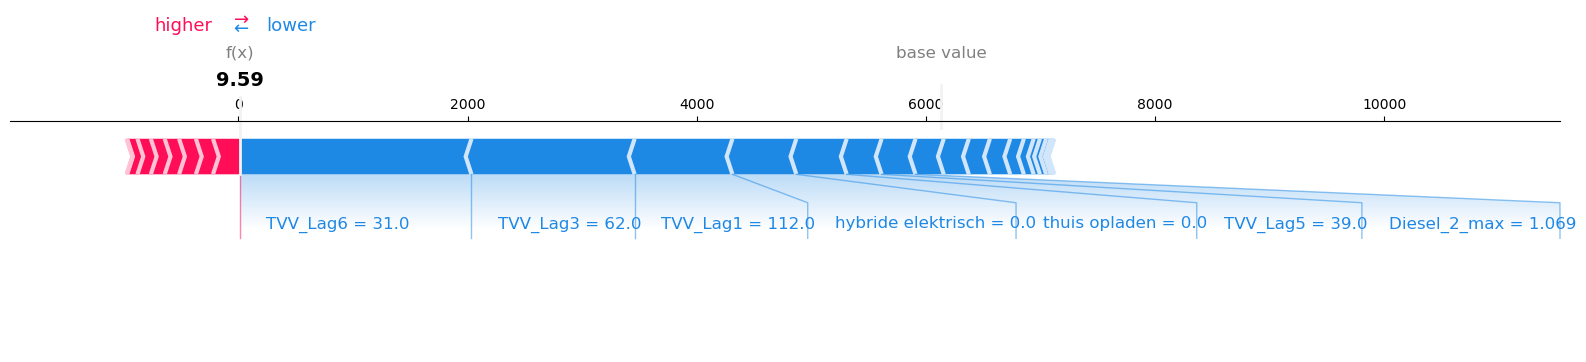

In [21]:
import shap

# Choose the model and feature set you want to explain, e.g., optimized XGBoost with all features
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    max_depth=3, learning_rate=0.2543, n_estimators=106, subsample=0.50, min_child_weight=8, colsample_bytree=0.39, 
    eval_metric="rmse"
)
X = df_lagged[all_features]
y = df_lagged['Totaal_verkochte_wegvoertuigen']
model.fit(X, y)

# Create SHAP explainer and calculate SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X, show=True)

# Force plot for a single prediction (e.g., first row)
shap.initjs()
shap.force_plot(
    shap_values.base_values[0],
    shap_values.values[0],
    X.iloc[0],
    matplotlib=True
)

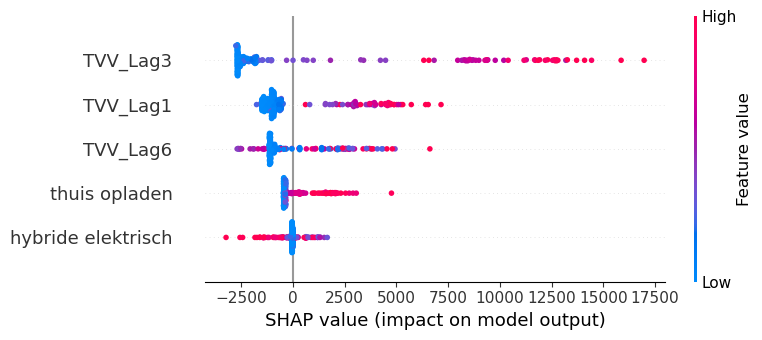

In [23]:
# Select the top N most important features based on cumulative SHAP values
N = 5  # You can change this number as needed

# Calculate feature importance from SHAP values and sort
shap_importance = np.abs(shap_values.values).mean(axis=0)
sorted_indices = np.argsort(shap_importance)[::-1]
sorted_features = [X.columns[i] for i in sorted_indices]

top_features = sorted_features[:N]

# Prepare validation data (X, y) for SHAP training
X_val = df_lagged[top_features]
y_val = df_lagged['Totaal_verkochte_wegvoertuigen']

# Train XGBoost model on validation set with only top features
model_val = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=all_params[0],
    learning_rate=all_params[1],
    n_estimators=all_params[2],
    subsample=all_params[3],
    min_child_weight=all_params[4],
    colsample_bytree=all_params[5],
    random_state=42,
    eval_metric="rmse"
)
model_val.fit(X_val, y_val)

# SHAP explanation for the validation model
explainer_val = shap.Explainer(model_val, X_val)
shap_values_val = explainer_val(X_val)

# Plot SHAP summary for the validation model with top features
shap.summary_plot(shap_values_val, X_val, show=True)

# Test

### LR

Linear Regression ( (Lag Only)) met scaling: MAPE=0.1142, MAE=2586.86, RMSE=3587.36, R²=0.563


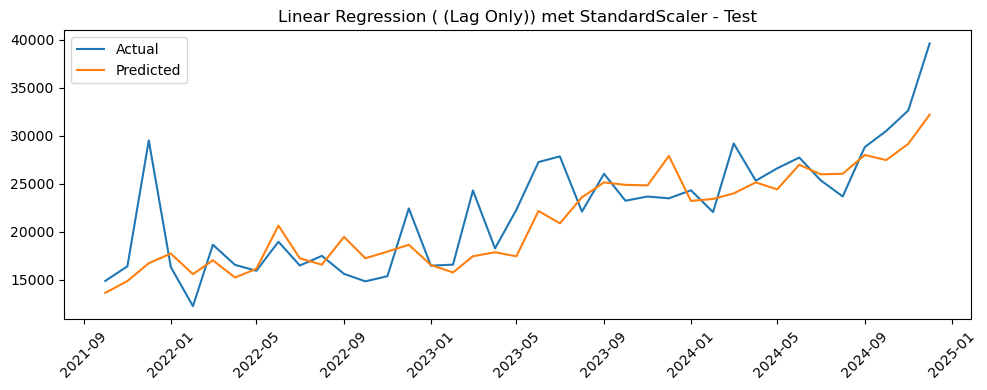

Linear Regression (All Features) met scaling: MAPE=0.1974, MAE=4161.57, RMSE=5300.73, R²=0.046


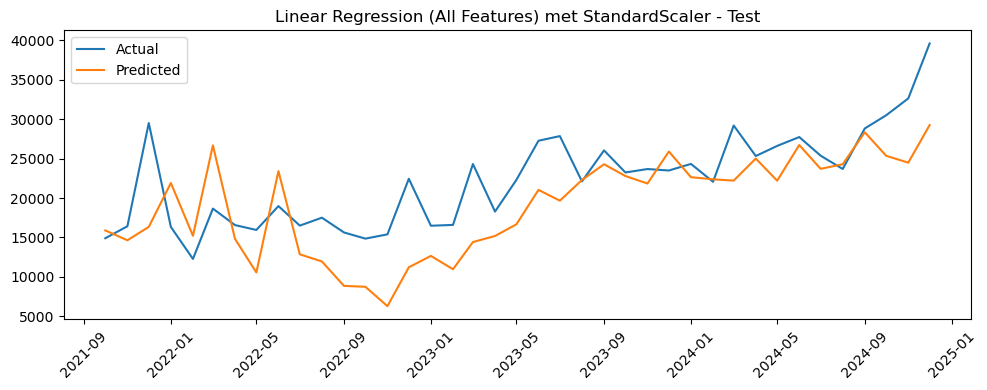

In [62]:
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    # Maak een pipeline met StandardScaler + LinearRegression
    model_pipeline = lambda: make_pipeline(StandardScaler(), LinearRegression())

    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates,test_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', model_pipeline, 
    )

    print(f"Linear Regression ({label}) met scaling: MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
    # Zet alles in een DataFrame om dubbele datums te verwijderen
    df_plot = pd.DataFrame({
        'date': pd.to_datetime(test_dates),
        'actual': actuals[:len(test_dates)],
        'pred': preds[:len(test_dates)]
    })
    df_plot = df_plot.drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(f'Linear Regression ({label}) met StandardScaler - Test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### wITHOUT SCALING

Linear Regression ( (Lag Only)): MAPE=0.1117, MAE=2546.43, RMSE=3521.89, R²=0.677


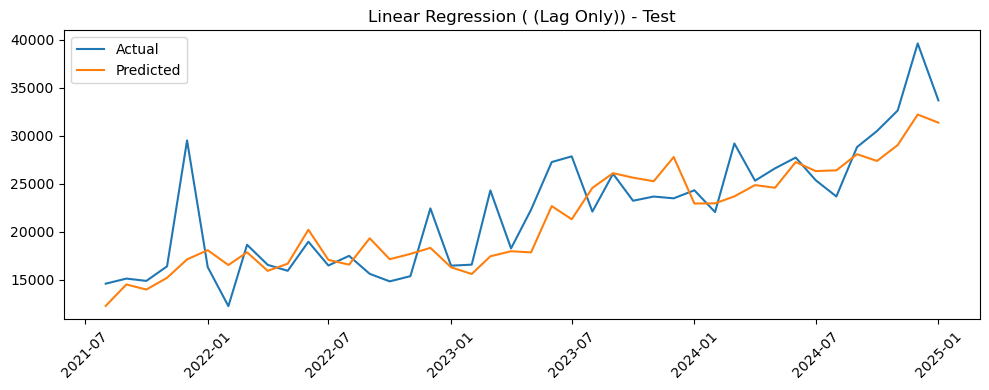

Linear Regression (All Features): MAPE=0.1632, MAE=3562.65, RMSE=4652.30, R²=0.437


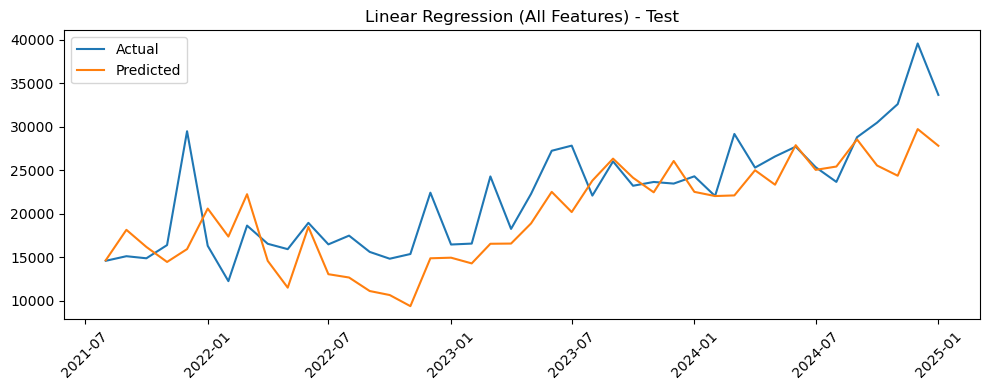

In [ ]:
# for label, features in feature_sets.items():
#     if label not in [' (Lag Only)', 'All Features']:
#         continue  # Sla andere feature sets over

#     (
#          mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#            df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression(), validation_size=1
#     )
#     print(f"Linear Regression ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")

#     # For test visualization (assuming monthly data)
#     test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

#     plt.figure(figsize=(10, 4))
#     plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
#     plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
#     plt.title(f'Linear Regression ({label}) - Test')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

#### Alle plots

Linear Regression ( (Lag Only)): MAPE=0.1117, MAE=2546.43, RMSE=3521.89, R²=0.677


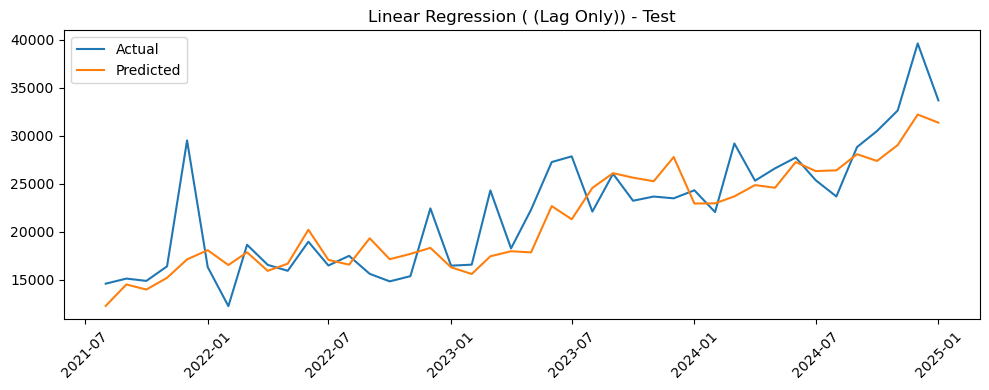

Linear Regression (Keywords + Lag): MAPE=0.1337, MAE=3042.31, RMSE=4226.67, R²=0.535


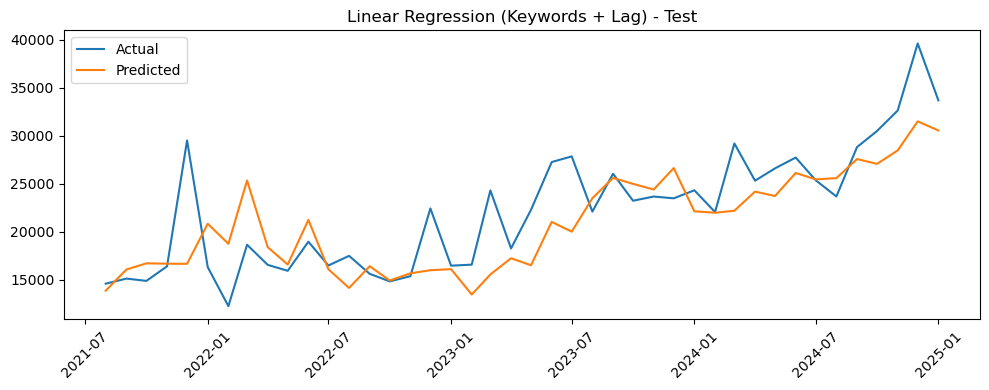

Linear Regression (Bijtelling + Lag): MAPE=0.1118, MAE=2552.88, RMSE=3529.13, R²=0.676


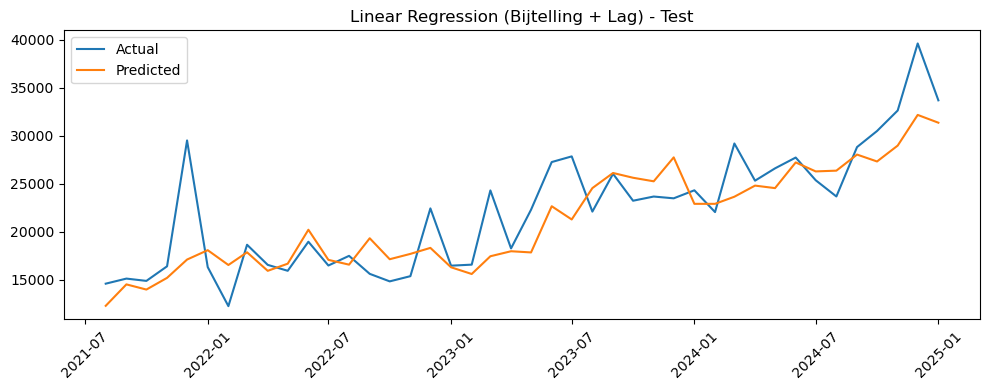

Linear Regression (Confidence + Lag): MAPE=0.1203, MAE=2784.75, RMSE=3871.54, R²=0.610


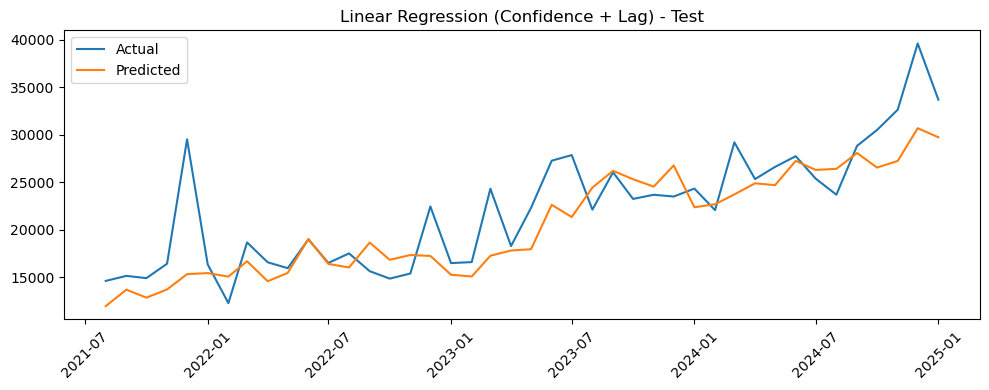

Linear Regression (Fuel + Lag): MAPE=0.1228, MAE=2713.82, RMSE=3589.39, R²=0.665


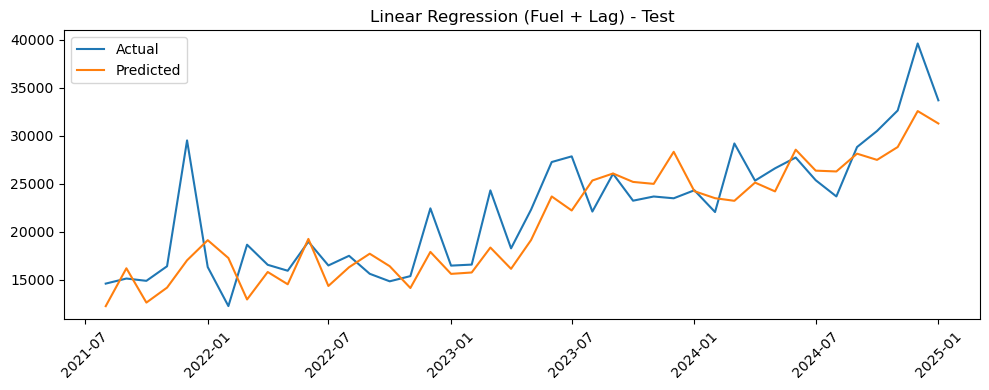

Linear Regression (All Features): MAPE=0.1632, MAE=3562.65, RMSE=4652.30, R²=0.437


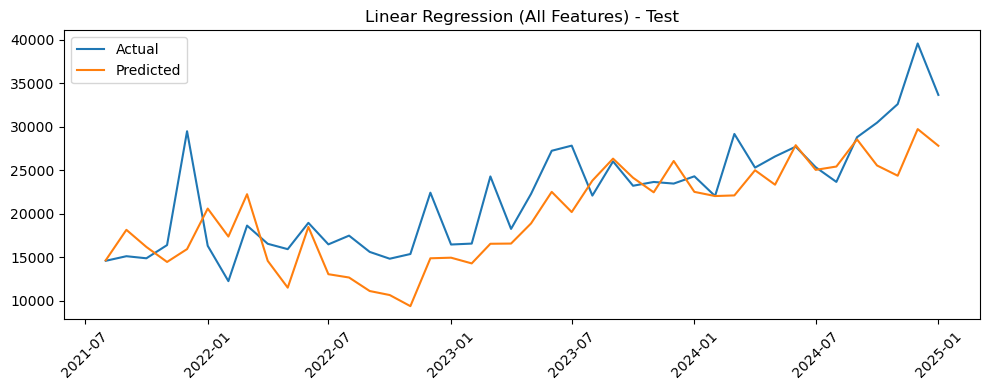

In [ ]:
# for label, features in feature_sets.items():
#     (
#         mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, test_mape, val_preds, test_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression(), validation_size=1
#     )
#     print(f"Linear Regression ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")

#     # For test visualization (assuming monthly data)
#     test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

#     plt.figure(figsize=(10, 4))
#     plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
#     plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
#     plt.title(f'Linear Regression ({label}) - Test')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

### Arimax

met scaling

ARIMAX ( (Lag Only)): MAPE=0.3207, MAE=6763.29, RMSE=8628.91, R²=-1.528
ARIMAX (All Features): MAPE=0.2410, MAE=5135.27, RMSE=7227.30, R²=-0.774


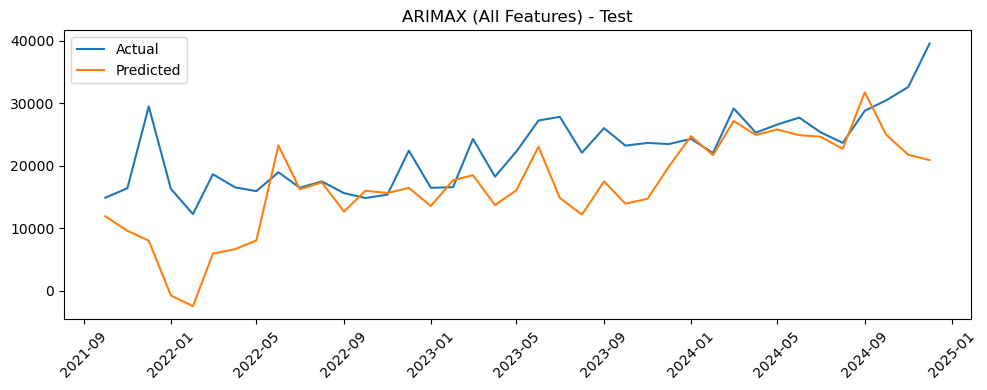

In [ ]:
from sklearn.preprocessing import StandardScaler

# ARIMAX wrapper met standaardisatie
class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model_fit = None
        self.scaler = None  # om later opnieuw te gebruiken bij predict
        
    def fit(self, X, y):
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        
        # Standaardiseer de exogene variabelen
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        model = SARIMAX(y, exog=X_scaled, order=self.order,
                        enforce_stationarity=False, enforce_invertibility=False)
        self.model_fit = model.fit(disp=False)
        return self
        
    def predict(self, X):
        if self.model_fit is None or self.scaler is None:
            raise ValueError("Model not fitted yet")
        
        X_scaled = self.scaler.transform(X)
        return self.model_fit.forecast(steps=len(X), exog=X_scaled)

for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    (
        mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates,test_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: ARIMAXWrapper(order=(1, 1, 1)),
        
    )
    print(f"ARIMAX ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")

     # Zet alles in een DataFrame om dubbele datums te verwijderen
df_plot = pd.DataFrame({
    'date': pd.to_datetime(test_dates),
    'actual': actuals[:len(test_dates)],
    'pred': preds[:len(test_dates)]
})
df_plot = df_plot.drop_duplicates(subset='date', keep='first')

plt.figure(figsize=(10, 4))
plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
plt.title(f'ARIMAX ({label}) - Test')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

    
    






#### wITHOUT SCALING

ARIMAX ( (Lag Only)): MAPE=1.2403, MAE=20805.91, RMSE=57715.63, R²=-85.693


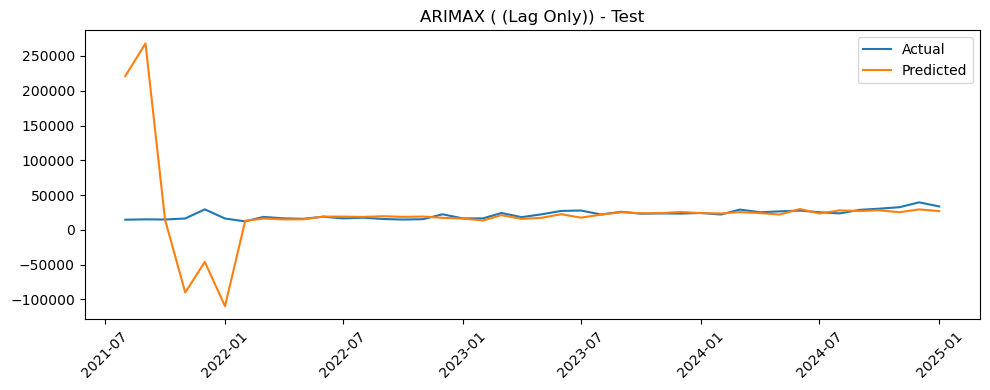

ARIMAX (All Features): MAPE=2.7928, MAE=50469.91, RMSE=89580.84, R²=-207.847


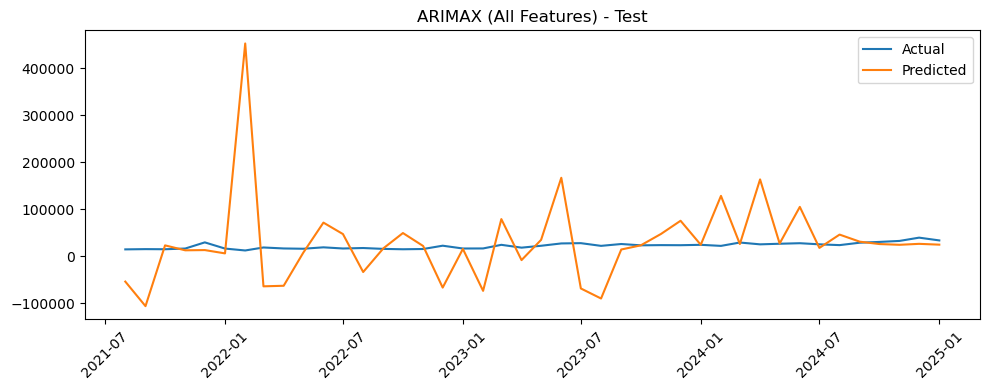

In [ ]:


# # First create a wrapper class for ARIMAX to make it compatible with walk_forward_validation
# class ARIMAXWrapper:
#     def __init__(self, order=(1,1,1)):
#         self.order = order
#         self.model_fit = None
        
#     def fit(self, X, y):
#         from statsmodels.tsa.statespace.sarimax import SARIMAX
#         model = SARIMAX(y, exog=X, order=self.order, enforce_stationarity=False, enforce_invertibility=False)
#         self.model_fit = model.fit(disp=False)
#         return self
        
#     def predict(self, X):
#         if self.model_fit is None:
#             raise ValueError("Model not fitted yet")
#         # For ARIMAX, predict uses forecast with exog data
#         return self.model_fit.forecast(steps=len(X), exog=X)

# # Now use this wrapper in your walk-forward validation to evaluate on the test set.
# for label, features in feature_sets.items():
#     if label not in [' (Lag Only)', 'All Features']:
#         continue  # Sla andere feature sets over

#     (
#          mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
#         lambda: ARIMAXWrapper(order=(1,1,1)),
#         validation_size=1
#     )
#     print(f"ARIMAX ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
#     # For test visualization (assuming monthly data)
#     test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

#     plt.figure(figsize=(10, 4))
#     plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
#     plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
#     plt.title(f'ARIMAX ({label}) - Test')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

#### Alle pots

In [ ]:
# # First create a wrapper class for ARIMAX to make it compatible with walk_forward_validation
# class ARIMAXWrapper:
#     def __init__(self, order=(1,1,1)):
#         self.order = order
#         self.model_fit = None
        
#     def fit(self, X, y):
#         from statsmodels.tsa.statespace.sarimax import SARIMAX
#         model = SARIMAX(y, exog=X, order=self.order, enforce_stationarity=False, enforce_invertibility=False)
#         self.model_fit = model.fit(disp=False)
#         return self
        
#     def predict(self, X):
#         if self.model_fit is None:
#             raise ValueError("Model not fitted yet")
#         # For ARIMAX, predict uses forecast with exog data
#         return self.model_fit.forecast(steps=len(X), exog=X)

# # Now use this wrapper in your walk-forward validation to evaluate on the test set.
# for label, features in feature_sets.items():
#     (
#          mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
#         lambda: ARIMAXWrapper(order=(1,1,1)),
#         validation_size=1
#     )
#     print(f"ARIMAX ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
#     # For test visualization (assuming monthly data)
#     test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

#     plt.figure(figsize=(10, 4))
#     plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
#     plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
#     plt.title(f'ARIMAX ({label}) - Test')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

### XGboost

#### parameters for lag only 

----- GRID SEARCH RESULTS -----

Best parameters (Lag-Only):
  max_depth=9, learning_rate=0.1, n_estimators=200
  subsample=1.0, min_child_weight=1, colsample_bytree=1.0
  Best MAPE: 0.1202, MAE: 2516.06


XGBoost ( (Lag Only)): MAPE=0.1522, MAE=3487.39, RMSE=4663.47, R²=0.261


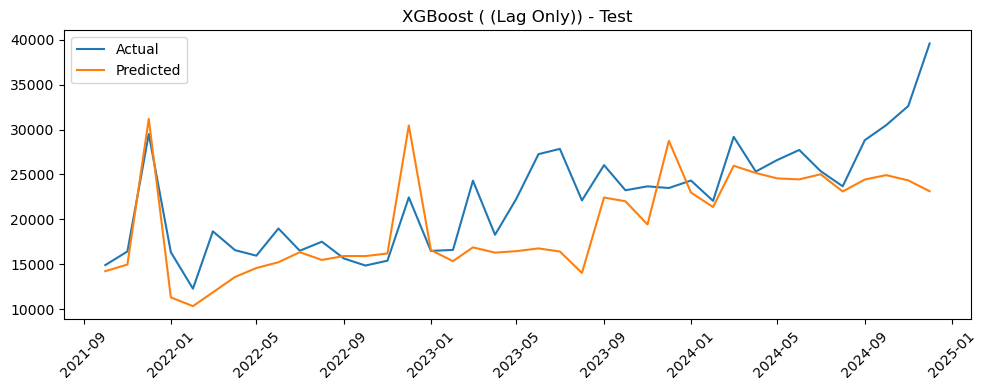

XGBoost (All Features): MAPE=0.1666, MAE=3929.22, RMSE=5075.13, R²=0.125


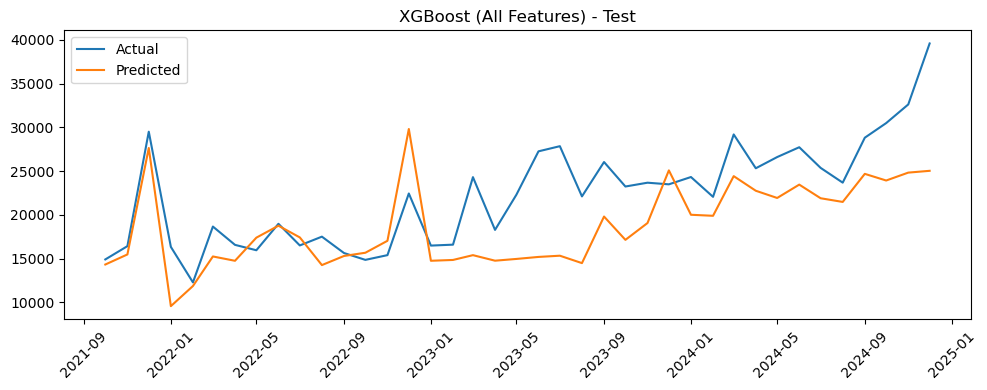

In [55]:

for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, test_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror', 
            max_depth=3, learning_rate=0.1, n_estimators=100,
            subsample=1.0, min_child_weight=1, colsample_bytree=1.0, 
            eval_metric="rmse"
        ),
    )
    print(f"XGBoost ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")

    # Zet alles in een DataFrame om dubbele datums te verwijderen
    df_plot = pd.DataFrame({
        'date': pd.to_datetime(test_dates),
        'actual': actuals,
        'pred': preds
    })

    # Verwijder dubbele datums, behoud de eerste voorspelling per datum
    df_plot = df_plot.drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(f'XGBoost ({label}) - Test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#### all features

In [ ]:
# for label, features in feature_sets.items():
#     (
#         mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
#         lambda: xgb.XGBRegressor(
#             objective='reg:squarederror', 
#             max_depth=7, learning_rate=0.0782, n_estimators=88, subsample=0.64, min_child_weight=9, colsample_bytree=0.78, 
#             eval_metric="rmse"
#         ),
#         validation_size=1
#     )
#     print(f"XGBoost ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
#     # For test visualization (assuming monthly data)
#     test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

#     plt.figure(figsize=(10, 4))
#     plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
#     plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
#     plt.title(f'XGBoost ({label}) - Test')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

#### parameters for all features



Best parameters (All Features):
  max_depth=3, learning_rate=0.1, n_estimators=200
  subsample=1.0, min_child_weight=1, colsample_bytree=1.0
  Best MAPE: 0.1202, MAE: 2580.19

hier wordt daadwerkelijk de test set gebruikt

XGBoost ( (Lag Only)): MAPE=0.1522, MAE=3487.39, RMSE=4663.47, R²=0.261


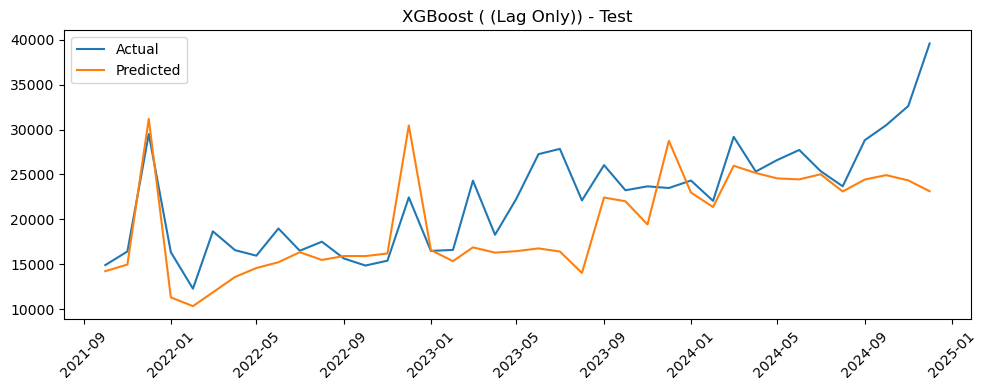

XGBoost (All Features): MAPE=0.1666, MAE=3929.22, RMSE=5075.13, R²=0.125


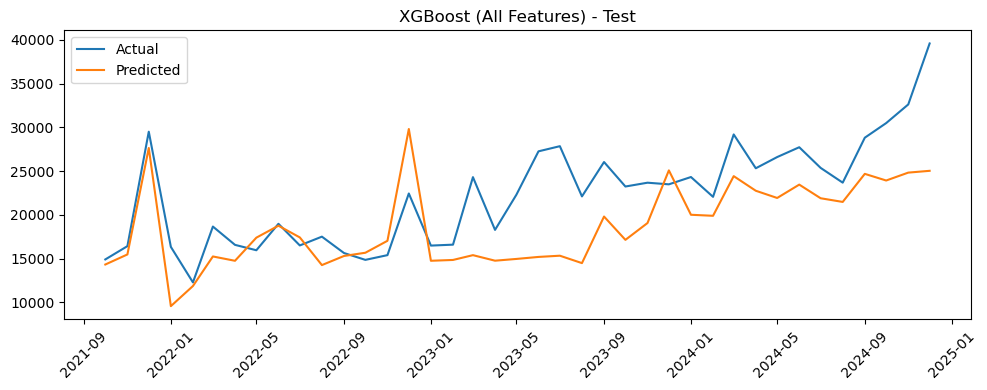

In [64]:
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue

    (
        mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals,
        validation_dates, test_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            max_depth=3, learning_rate=0.1, n_estimators=100,
            subsample=1.0, min_child_weight=1, colsample_bytree=1.0,
            eval_metric="rmse"
        )
    )

    print(f"XGBoost ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")

     # Zet alles in een DataFrame om dubbele datums te verwijderen
    df_plot = pd.DataFrame({
        'date': pd.to_datetime(test_dates),
        'actual': actuals,
        'pred': preds
    })

    # Verwijder dubbele datums, behoud de eerste voorspelling per datum
    df_plot = df_plot.drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(f'XGBoost ({label}) - Test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### All features 

In [ ]:
# for label, features in feature_sets.items():
#     (
#         mae, rmse, r2, mape, preds, actuals,
#         val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
#         lambda: xgb.XGBRegressor(
#             objective='reg:squarederror', 
#             max_depth=3, learning_rate=0.2543, n_estimators=106, subsample=0.50, min_child_weight=8, colsample_bytree=0.39, 
#             eval_metric="rmse"
#         ),
#         validation_size=1
#     )
#     print(f"XGBoost ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
#     # For test visualization (assuming monthly data)
#     test_dates = [pd.to_datetime(date) + pd.DateOffset(months=1) for date in validation_dates]

#     plt.figure(figsize=(10, 4))
#     plt.plot(test_dates, actuals[:len(test_dates)], label='Actual')
#     plt.plot(test_dates, preds[:len(test_dates)], label='Predicted')
#     plt.title(f'XGBoost ({label}) - Test')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()